# Regression Week 4: Ridge Regression (interpretation)

In this notebook, we will run ridge regression multiple times with different L2 penalties to see which one produces the best fit. We will revisit the example of polynomial regression as a means to see the effect of L2 regularization. In particular, we will:
* Use a pre-built implementation of regression (Turi Create) to run polynomial regression
* Use matplotlib to visualize polynomial regressions
* Use a pre-built implementation of regression (Turi Create) to run polynomial regression, this time with L2 penalty
* Use matplotlib to visualize polynomial regressions under L2 regularization
* Choose best L2 penalty using cross-validation.
* Assess the final fit using test data.

We will continue to use the House data from previous notebooks.  (In the next programming assignment for this module, you will implement your own ridge regression learning algorithm using gradient descent.)

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import Ridge
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int, 'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

# Polynomial regression, revisited

We build on the material from Week 3, where we wrote the function to produce an SFrame with columns containing the powers of a given input. Copy and paste the function `polynomial_sframe` from Week 3:

In [2]:
def polynomial_dataframe(feature, degree): # feature is pandas.Series type
    # assume that degree >= 1
    # initialize the dataframe:
    poly_dataframe = pd.DataFrame()
    # and set poly_dataframe['power_1'] equal to the passed feature
    poly_dataframe['power_1']=feature
    # first check if degree > 1
    if degree > 1:
        # then loop over the remaining degrees:
        for power in range(2, degree+1):
            # first we'll give the column a name:
            name = 'power_' + str(power)
            # assign poly_dataframe[name] to be feature^power; use apply(*)
            poly_dataframe[name]=feature**power
    return poly_dataframe
    

Let's use matplotlib to visualize what a polynomial regression looks like on the house data.

In [3]:
import matplotlib.pyplot as plt

In [4]:
sales=pd.read_csv("kc_house_data.csv", dtype=dtype_dict)

As in Week 3, we will use the sqft_living variable. For plotting purposes (connecting the dots), you'll need to sort by the values of sqft_living. For houses with identical square footage, we break the tie by their prices.

In [5]:
sales = sales.sort_values(['sqft_living','price'])
poly15_data = polynomial_dataframe(sales['sqft_living'], 15)
my_features_15 =poly15_data.columns
poly15_data['price'] = sales['price'] # add price to the data since it's the target


Let us revisit the 15th-order polynomial model using the 'sqft_living' input. Generate polynomial features up to degree 15 using `polynomial_sframe()` and fit a model with these features. When fitting the model, use an L2 penalty of `1e-5`:

In [6]:
l2_small_penalty = 1.5e-5
model=Ridge(alpha=l2_small_penalty,normalize=True)
model.fit(poly15_data[my_features_15],poly15_data['price'])
print(model.intercept_)
model.coef_

220664.37505375536


array([ 1.24873306e+02, -4.77376011e-02,  3.01446238e-05, -2.44419942e-09,
       -1.94153675e-13,  8.54085686e-18,  1.51142121e-21,  8.27979094e-26,
        6.52603100e-31, -3.27895017e-34, -3.87962315e-38, -2.72437650e-42,
       -1.07790800e-46,  3.78242694e-51,  1.39790296e-54])

Note: When we have so many features and so few data points, the solution can become highly numerically unstable, which can sometimes lead to strange unpredictable results.  Thus, rather than using no regularization, we will introduce a tiny amount of regularization (`l2_penalty=1e-5`) to make the solution numerically stable.  (In lecture, we discussed the fact that regularization can also help with numerical stability, and here we are seeing a practical example.)

With the L2 penalty specified above, fit the model and print out the learned weights.

Hint: make sure to add 'price' column to the new SFrame before calling `turicreate.linear_regression.create()`. Also, make sure Turi Create doesn't create its own validation set by using the option `validation_set=None` in this call.

***QUIZ QUESTION:  What's the learned value for the coefficient of feature `power_1`?***

# Observe overfitting

Recall from Week 3 that the polynomial fit of degree 15 changed wildly whenever the data changed. In particular, when we split the sales data into four subsets and fit the model of degree 15, the result came out to be very different for each subset. The model had a *high variance*. We will see in a moment that ridge regression reduces such variance. But first, we must reproduce the experiment we did in Week 3.

First, split the data into split the sales data into four subsets of roughly equal size and call them `set_1`, `set_2`, `set_3`, and `set_4`. Use `.random_split` function and make sure you set `seed=0`. 

In [7]:
set1=pd.read_csv("wk3_kc_house_set_1_data.csv", dtype=dtype_dict)
set2=pd.read_csv("wk3_kc_house_set_2_data.csv", dtype=dtype_dict)
set3=pd.read_csv("wk3_kc_house_set_3_data.csv", dtype=dtype_dict)
set4=pd.read_csv("wk3_kc_house_set_4_data.csv", dtype=dtype_dict)

Next, fit a 15th degree polynomial on `set_1`, `set_2`, `set_3`, and `set_4`, using 'sqft_living' to predict prices. Print the weights and make a plot of the resulting model.

Hint: When calling `turicreate.linear_regression.create()`, use the same L2 penalty as before (i.e. `l2_small_penalty`).  Also, make sure Turi Create doesn't create its own validation set by using the option `validation_set = None` in this call.

[ 5.44669398e+02 -3.55447605e-01  1.22446382e-04 -1.17175318e-08
 -3.90512295e-13 -1.39076633e-17  1.47860337e-20  6.87491612e-25
 -7.57203949e-29 -1.04097310e-32 -3.71844032e-37  3.39989217e-41
  5.56592061e-45  2.53761389e-49 -3.35152920e-53]


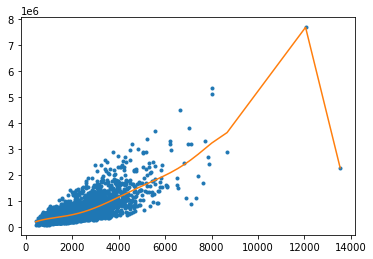

In [8]:
poly15_data_s1 = polynomial_dataframe(set1['sqft_living'], 15)
my_features_15_s1 =poly15_data_s1.columns
poly15_data_s1['price'] = set1['price'] # add price to the data since it's the target
l2_small_penalty =1e-9
model_s1=Ridge(alpha=l2_small_penalty,normalize=True)
model_s1.fit(poly15_data_s1[my_features_15_s1],poly15_data_s1['price'])
print(model_s1.coef_)

plt.plot(poly15_data_s1['power_1'],poly15_data_s1['price'],'.',
         poly15_data_s1['power_1'], model_s1.predict(poly15_data_s1[my_features_15_s1]),'-')

[ 8.59362708e+02 -8.18118359e-01  4.28880039e-04 -9.12770851e-08
 -2.69604178e-12  3.73980340e-15 -1.42711999e-19 -6.30794724e-23
 -1.44559331e-27  7.44321122e-31  9.25865888e-35  3.28003549e-41
 -1.29543509e-42 -1.38781229e-46  1.66546428e-50]


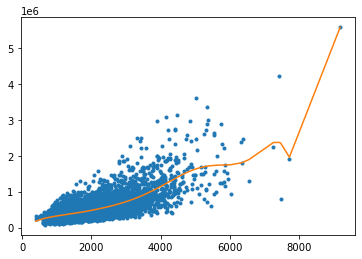

In [9]:
poly15_data_s2 = polynomial_dataframe(set2['sqft_living'], 15)
my_features_15_s2 =poly15_data_s2.columns
poly15_data_s2['price'] = set2['price'] # add price to the data since it's the target
l2_small_penalty = 1e-9

model_s2=Ridge(alpha=l2_small_penalty,normalize=True)
model_s2.fit(poly15_data_s2[my_features_15_s2],poly15_data_s2['price'])
print(model_s2.coef_)

plt.plot(poly15_data_s2['power_1'],poly15_data_s2['price'],'.',
        poly15_data_s2['power_1'], model_s2.predict(poly15_data_s2[my_features_15_s2]),'-')

[-7.55395833e+02  9.75579394e-01 -4.58945927e-04  7.77957900e-08
  7.15013680e-12 -2.88602015e-15 -2.13677510e-20  3.38085163e-23
  2.19178186e-27 -1.97067716e-31 -4.15993193e-35 -1.80196139e-39
  3.19071101e-43  5.08456929e-47 -3.93304253e-51]


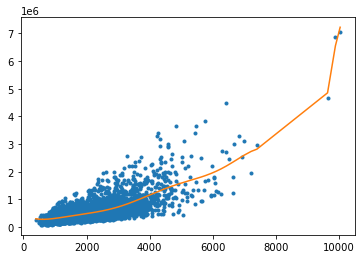

In [10]:
set3 = set3.sort_values(['sqft_living','price'])
poly15_data_s3 = polynomial_dataframe(set3['sqft_living'], 15)
my_features_15_s3 =poly15_data_s3.columns
poly15_data_s3['price'] = set3['price'] # add price to the data since it's the target
l2_small_penalty = 1e-9
model_s3=Ridge(alpha=l2_small_penalty,normalize=True)
model_s3.fit(poly15_data_s3[my_features_15_s3],poly15_data_s3['price'])
print(model_s3.coef_)

plt.plot(poly15_data_s3['power_1'],poly15_data_s3['price'],'.',
         poly15_data_s3['power_1'], model_s3.predict(poly15_data_s3[my_features_15_s3]),'-')

[ 1.11944577e+03 -9.83760304e-01  3.38770976e-04  3.60376822e-08
 -4.37813907e-11  5.77191517e-15  7.66795319e-19 -9.49297560e-23
 -1.96030835e-26 -2.10882333e-32  3.31005148e-34  3.47733760e-38
 -2.43039208e-42 -8.79553271e-46  6.44569668e-50]


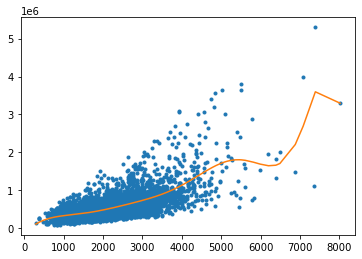

In [11]:
poly15_data_s4 = polynomial_dataframe(set4['sqft_living'], 15)
my_features_15_s4 =poly15_data_s4.columns
poly15_data_s4['price'] = set4['price'] # add price to the data since it's the target
l2_small_penalty = 1e-9
model_s4=Ridge(alpha=l2_small_penalty,normalize=True)
model_s4.fit(poly15_data_s4[my_features_15_s4],poly15_data_s4['price'])
print(model_s4.coef_)

plt.plot(poly15_data_s4['power_1'],poly15_data_s4['price'],'.',
         poly15_data_s4['power_1'], model_s4.predict(poly15_data_s4[my_features_15_s4]),'-')

The four curves should differ from one another a lot, as should the coefficients you learned.

***QUIZ QUESTION:  For the models learned in each of these training sets, what are the smallest and largest values you learned for the coefficient of feature `power_1`?***  (For the purpose of answering this question, negative numbers are considered "smaller" than positive numbers. So -5 is smaller than -3, and -3 is smaller than 5 and so forth.)

# Ridge regression comes to rescue

Generally, whenever we see weights change so much in response to change in data, we believe the variance of our estimate to be large. Ridge regression aims to address this issue by penalizing "large" weights. (Weights of `model15` looked quite small, but they are not that small because 'sqft_living' input is in the order of thousands.)

With the argument `l2_penalty=1e5`, fit a 15th-order polynomial model on `set_1`, `set_2`, `set_3`, and `set_4`. Other than the change in the `l2_penalty` parameter, the code should be the same as the experiment above. Also, make sure Turi Create doesn't create its own validation set by using the option `validation_set = None` in this call.

[2.32806803e+00 3.53621608e-04 3.31969692e-08 2.00082477e-12
 1.11492559e-16 6.57786122e-21 4.12939525e-25 2.70393755e-29
 1.81614763e-33 1.23824277e-37 8.51872481e-42 5.89455598e-46
 4.09542560e-50 2.85464889e-54 1.99547476e-58]


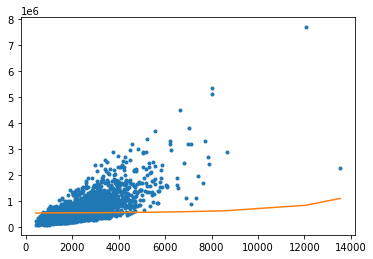

In [12]:
poly15_data_s1 = polynomial_dataframe(set1['sqft_living'], 15)
my_features_15_s1 =poly15_data_s1.columns
poly15_data_s1['price'] = set1['price'] # add price to the data since it's the target
l2_penalty = 1.23e2
model_s1=Ridge(alpha=l2_penalty,normalize=True)
model_s1.fit(poly15_data_s1[my_features_15_s1],poly15_data_s1['price'])
print(model_s1.coef_)

plt.plot(poly15_data_s1['power_1'],poly15_data_s1['price'],'.',
         poly15_data_s1['power_1'], model_s1.predict(poly15_data_s1[my_features_15_s1]),'-')

[2.09756903e+00 3.90817483e-04 6.67189944e-08 8.90002997e-12
 9.72639877e-16 9.69733682e-20 9.50564475e-24 9.44491031e-28
 9.57191338e-32 9.86945155e-36 1.03101115e-39 1.08729784e-43
 1.15453748e-47 1.23211305e-51 1.31986696e-55]


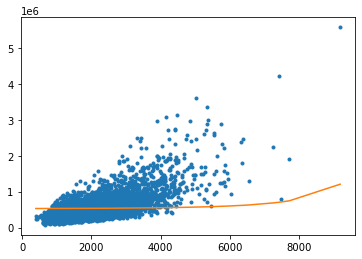

In [13]:
set2 = set2.sort_values(['sqft_living','price'])
poly15_data_s2 = polynomial_dataframe(set2['sqft_living'], 15)
my_features_15_s2 =poly15_data_s2.columns
poly15_data_s2['price'] = set2['price'] # add price to the data since it's the target
l2_penalty = 1.23e2
model_s2=Ridge(alpha=l2_penalty,normalize=True)
model_s2.fit(poly15_data_s2[my_features_15_s2],poly15_data_s2['price'])
print(model_s2.coef_)

plt.plot(poly15_data_s2['power_1'],poly15_data_s2['price'],'.',
        poly15_data_s2['power_1'], model_s2.predict(poly15_data_s2[my_features_15_s2]),'-')

[2.28906258e+00 4.12472190e-04 6.08835345e-08 6.58572163e-12
 6.15278155e-16 5.64446634e-20 5.28834396e-24 5.07091402e-28
 4.94657273e-32 4.88043809e-36 4.85009106e-40 4.84161534e-44
 4.84635021e-48 4.85883628e-52 4.87558469e-56]


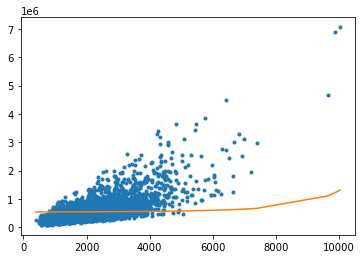

In [14]:
set3 = set3.sort_values(['sqft_living','price'])
poly15_data_s3 = polynomial_dataframe(set3['sqft_living'], 15)
my_features_15_s3 =poly15_data_s3.columns
poly15_data_s3['price'] = set3['price'] # add price to the data since it's the target
l2_penalty =1.23e2
model_s3=Ridge(alpha=l2_penalty,normalize=True)
model_s3.fit(poly15_data_s3[my_features_15_s3],poly15_data_s3['price'])
print(model_s3.coef_)

plt.plot(poly15_data_s3['power_1'],poly15_data_s3['price'],'.',
         poly15_data_s3['power_1'], model_s3.predict(poly15_data_s3[my_features_15_s3]),'-')

[2.08596194e+00 4.05035772e-04 7.46864647e-08 1.13096608e-11
 1.45864442e-15 1.73561251e-19 2.01609632e-23 2.34605255e-27
 2.75636073e-31 3.27043069e-35 3.91046855e-39 4.70118041e-43
 5.67212304e-47 6.85958087e-51 8.30843630e-55]


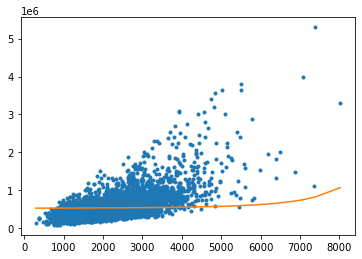

In [15]:
set4 = set4.sort_values(['sqft_living','price'])
poly15_data_s4 = polynomial_dataframe(set4['sqft_living'], 15)
my_features_15_s4 =poly15_data_s4.columns
poly15_data_s4['price'] = set4['price'] # add price to the data since it's the target
l2_penalty = 1.23e2
model_s4=Ridge(alpha=l2_penalty,normalize=True)
model_s4.fit(poly15_data_s4[my_features_15_s4],poly15_data_s4['price'])
print(model_s4.coef_)

plt.plot(poly15_data_s4['power_1'],poly15_data_s4['price'],'.',
         poly15_data_s4['power_1'], model_s4.predict(poly15_data_s4[my_features_15_s4]),'-')

These curves should vary a lot less, now that you applied a high degree of regularization.

***QUIZ QUESTION:  For the models learned with the high level of regularization in each of these training sets, what are the smallest and largest values you learned for the coefficient of feature `power_1`?*** (For the purpose of answering this question, negative numbers are considered "smaller" than positive numbers. So -5 is smaller than -3, and -3 is smaller than 5 and so forth.)

# Selecting an L2 penalty via cross-validation

Just like the polynomial degree, the L2 penalty is a "magic" parameter we need to select. We could use the validation set approach as we did in the last module, but that approach has a major disadvantage: it leaves fewer observations available for training. **Cross-validation** seeks to overcome this issue by using all of the training set in a smart way.

We will implement a kind of cross-validation called **k-fold cross-validation**. The method gets its name because it involves dividing the training set into k segments of roughtly equal size. Similar to the validation set method, we measure the validation error with one of the segments designated as the validation set. The major difference is that we repeat the process k times as follows:

Set aside segment 0 as the validation set, and fit a model on rest of data, and evalutate it on this validation set<br>
Set aside segment 1 as the validation set, and fit a model on rest of data, and evalutate it on this validation set<br>
...<br>
Set aside segment k-1 as the validation set, and fit a model on rest of data, and evalutate it on this validation set

After this process, we compute the average of the k validation errors, and use it as an estimate of the generalization error. Notice that  all observations are used for both training and validation, as we iterate over segments of data. 

To estimate the generalization error well, it is crucial to shuffle the training data before dividing them into segments. The package turicreate_cross_validation (see below) has a utility function for shuffling a given SFrame. We reserve 10% of the data as the test set and shuffle the remainder. (Make sure to use `seed=1` to get consistent answer.)

  
_Note:_ For applying cross-validation, we will import a package called `turicreate_cross_validation`. To install it, please run this command on your terminal:

`pip install -e git+https://github.com/Kagandi/turicreate-cross-validation.git#egg=turicreate_cross_validation`

You can find the documentation on this package here: https://github.com/Kagandi/turicreate-cross-validation

In [16]:
train_valid_shuffled = pd.read_csv('wk3_kc_house_train_valid_shuffled.csv', dtype=dtype_dict)
test = pd.read_csv('wk3_kc_house_test_data.csv', dtype=dtype_dict)

Once the data is shuffled, we divide it into equal segments. Each segment should receive `n/k` elements, where `n` is the number of observations in the training set and `k` is the number of segments. Since the segment 0 starts at index 0 and contains `n/k` elements, it ends at index `(n/k)-1`. The segment 1 starts where the segment 0 left off, at index `(n/k)`. With `n/k` elements, the segment 1 ends at index `(n*2/k)-1`. Continuing in this fashion, we deduce that the segment `i` starts at index `(n*i/k)` and ends at `(n*(i+1)/k)-1`.

With this pattern in mind, we write a short loop that prints the starting and ending indices of each segment, just to make sure you are getting the splits right.

In [17]:
n = len(train_valid_shuffled)
k = 10 #-fold cross-validation

print(n)
for i in range(k):
   
    start = (n*i)//k
    end = (n*(i+1))//k-1
    print (i , start, end)

19396
0 0 1938
1 1939 3878
2 3879 5817
3 5818 7757
4 7758 9697
5 9698 11636
6 11637 13576
7 13577 15515
8 15516 17455
9 17456 19395


Let us familiarize ourselves with array slicing with SFrame. To extract a continuous slice from an SFrame, use colon in square brackets. For instance, the following cell extracts rows 0 to 9 of `train_valid_shuffled`. Notice that the first index (0) is included in the slice but the last index (10) is omitted.

In [18]:
train_valid_shuffled[0:10] # rows 0 to 9

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2780400035,20140505T000000,665000.0,4.0,2.50,2800.0,5900,1.0,0,0,...,8,1660,1140,1963,0,98115,47.6809,-122.286,2580.0,5900.0
1,1703050500,20150321T000000,645000.0,3.0,2.50,2490.0,5978,2.0,0,0,...,9,2490,0,2003,0,98074,47.6298,-122.022,2710.0,6629.0
2,5700002325,20140605T000000,640000.0,3.0,1.75,2340.0,4206,1.0,0,0,...,7,1170,1170,1917,0,98144,47.5759,-122.288,1360.0,4725.0
3,0475000510,20141118T000000,594000.0,3.0,1.00,1320.0,5000,1.0,0,0,...,7,1090,230,1920,0,98107,47.6674,-122.365,1700.0,5000.0
4,0844001052,20150128T000000,365000.0,4.0,2.50,1904.0,8200,2.0,0,0,...,7,1904,0,1999,0,98010,47.3107,-122.001,1560.0,12426.0
5,2781280290,20150427T000000,305000.0,3.0,2.50,1610.0,3516,2.0,0,0,...,8,1610,0,2006,0,98055,47.4491,-122.188,1610.0,3056.0
6,2214800630,20141105T000000,239950.0,3.0,2.25,1560.0,8280,2.0,0,0,...,7,1560,0,1979,0,98001,47.3393,-122.259,1920.0,8120.0
7,2114700540,20141021T000000,366000.0,3.0,2.50,1320.0,4320,1.0,0,0,...,6,660,660,1918,0,98106,47.5327,-122.347,1190.0,4200.0
8,2596400050,20140730T000000,375000.0,3.0,1.00,1960.0,7955,1.0,0,0,...,7,1260,700,1963,0,98177,47.7641,-122.364,1850.0,8219.0
9,4140900050,20150126T000000,440000.0,4.0,1.75,2180.0,10200,1.0,0,2,...,8,2000,180,1966,0,98028,47.7638,-122.270,2590.0,10445.0


Now let us extract individual segments with array slicing. Consider the scenario where we group the houses in the `train_valid_shuffled` dataframe into k=10 segments of roughly equal size, with starting and ending indices computed as above.
Extract the fourth segment (segment 3) and assign it to a variable called `validation4`.

In [19]:
s=(n*3)//k
e=(n*(3+1))//k-1
print(s,e)
validation4=train_valid_shuffled[s:e]

5818 7757


To verify that we have the right elements extracted, run the following cell, which computes the average price of the fourth segment. When rounded to nearest whole number, the average should be $559,642.

In [20]:
print (int(round(validation4['price'].mean(), 0)))

536353


After designating one of the k segments as the validation set, we train a model using the rest of the data. To choose the remainder, we slice (0:start) and (end+1:n) of the data and paste them together. SFrame has `append()` method that pastes together two disjoint sets of rows originating from a common dataset. For instance, the following cell pastes together the first and last two rows of the `train_valid_shuffled` dataframe.

In [21]:
n = len(train_valid_shuffled)
first_two = train_valid_shuffled[0:2]
last_two = train_valid_shuffled[n-2:n]
print (first_two.append(last_two))

               id             date      price  bedrooms  bathrooms  \
0      2780400035  20140505T000000   665000.0       4.0       2.50   
1      1703050500  20150321T000000   645000.0       3.0       2.50   
19394  4139480190  20140916T000000  1153000.0       3.0       3.25   
19395  7237300290  20150326T000000   338000.0       5.0       2.50   

       sqft_living  sqft_lot  floors  waterfront  view  ...  grade  \
0           2800.0      5900     1.0           0     0  ...      8   
1           2490.0      5978     2.0           0     0  ...      9   
19394       3780.0     10623     1.0           0     1  ...     11   
19395       2400.0      4496     2.0           0     0  ...      7   

       sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat  \
0            1660           1140      1963             0    98115  47.6809   
1            2490              0      2003             0    98074  47.6298   
19394        2650           1130      1999             0    9800

Extract the remainder of the data after *excluding* fourth segment (segment 3) and assign the subset to `train4`.

In [22]:
sn=s-1
en=e+1
first_part = train_valid_shuffled[0:sn-1]
last_part = train_valid_shuffled[en+1:]
train_4 = first_part.append(last_part)

To verify that we have the right elements extracted, run the following cell, which computes the average price of the data with fourth segment excluded. When rounded to nearest whole number, the average should be $536,865.

In [23]:
print (int(round(train_4['price'].mean(), 0)))

539405


Now we are ready to implement k-fold cross-validation. Write a function that computes k validation errors by designating each of the k segments as the validation set. It accepts as parameters (i) `k`, (ii) `l2_penalty`, (iii) dataframe, (iv) name of output column (e.g. `price`) and (v) list of feature names. The function returns the average validation error using k segments as validation sets.

* For each i in [0, 1, ..., k-1]:
  * Compute starting and ending indices of segment i and call 'start' and 'end'
  * Form validation set by taking a slice (start:end+1) from the data.
  * Form training set by appending slice (end+1:n) to the end of slice (0:start).
  * Train a linear model using training set just formed, with a given l2_penalty
  * Compute validation error using validation set just formed

In [32]:
def k_fold_cross_validation(k, l2_penalty, data, output_name, features_list):
    rss_ind=0
    for i in range (k):
        start = (n*i)//k
        end = (n*(i+1))//k-1
        print("start",start,"end",end)
        valid_s=data[start:end+1]
        t1=data[0:start]
        t2=data[end+1:n]
        train_s=t1.append(t2)
        print("validation",valid_s,"part1",t1,"part2",t2)
        model=Ridge(alpha=l2_penalty,normalize=True)
        model.fit(train_s[features_list],train_s[output_name])
        y_v=model.predict(valid_s[features_list])
        error=valid_s[output_name]-y_v
        rss_s=(error*error)
        rss_ind+=sum(rss_s)

    avg=(rss_ind)/k
    return avg
    

Once we have a function to compute the average validation error for a model, we can write a loop to find the model that minimizes the average validation error. Write a loop that does the following:
* We will again be aiming to fit a 15th-order polynomial model using the `sqft_living` input
* For `l2_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, you can use this Numpy function: `np.logspace(1, 7, num=13)`.)
    * Run 10-fold cross-validation with `l2_penalty`
* Report which L2 penalty produced the lowest average validation error.

Note: since the degree of the polynomial is now fixed to 15, to make things faster, you should generate polynomial features in advance and re-use them throughout the loop. Make sure to use `train_valid_shuffled` when generating polynomial features!

In [33]:
train_15= polynomial_dataframe(train_valid_shuffled['sqft_living'], 15)
list1=[]
my_features_15 =train_15.columns
train_15['price'] = train_valid_shuffled['price'] # add price to the data since it's the target 
penalty_list=np.logspace(3, 9, num=13)
for l2_penalty in (penalty_list):
       # print("penalty",l2_penalty)
        #print("rss",k_fold_cross_validation(10, l2_penalty, train_15, 'price', my_features_15))
        rss_v=k_fold_cross_validation(10, l2_penalty, train_15, 'price', my_features_15)
        list1.append(rss_v)

start 0 end 1938
validation       power_1    power_2       power_3       power_4       power_5  \
0      2800.0  7840000.0  2.195200e+10  6.146560e+13  1.721037e+17   
1      2490.0  6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
2      2340.0  5475600.0  1.281290e+10  2.998220e+13  7.015834e+16   
3      1320.0  1742400.0  2.299968e+09  3.035958e+12  4.007464e+15   
4      1904.0  3625216.0  6.902411e+09  1.314219e+13  2.502273e+16   
...       ...        ...           ...           ...           ...   
1934   1940.0  3763600.0  7.301384e+09  1.416468e+13  2.747949e+16   
1935   1150.0  1322500.0  1.520875e+09  1.749006e+12  2.011357e+15   
1936   2220.0  4928400.0  1.094105e+10  2.428913e+13  5.392186e+16   
1937   1950.0  3802500.0  7.414875e+09  1.445901e+13  2.819506e+16   
1938   2432.0  5914624.0  1.438437e+10  3.498278e+13  8.507811e+16   

           power_6       power_7       power_8       power_9      power_10  \
0     4.818903e+20  1.349293e+24  3.778020e+27  1.057

[15517 rows x 16 columns]
start 3879 end 5817
validation       power_1     power_2       power_3       power_4       power_5  \
3879   1340.0   1795600.0  2.406104e+09  3.224179e+12  4.320400e+15   
3880   1020.0   1040400.0  1.061208e+09  1.082432e+12  1.104081e+15   
3881   2640.0   6969600.0  1.839974e+10  4.857532e+13  1.282389e+17   
3882   2390.0   5712100.0  1.365192e+10  3.262809e+13  7.798113e+16   
3883   2970.0   8820900.0  2.619807e+10  7.780828e+13  2.310906e+17   
...       ...         ...           ...           ...           ...   
5813   1360.0   1849600.0  2.515456e+09  3.421020e+12  4.652587e+15   
5814   2850.0   8122500.0  2.314912e+10  6.597501e+13  1.880288e+17   
5815   1330.0   1768900.0  2.352637e+09  3.129007e+12  4.161580e+15   
5816   3370.0  11356900.0  3.827275e+10  1.289792e+14  4.346598e+17   
5817   2700.0   7290000.0  1.968300e+10  5.314410e+13  1.434891e+17   

           power_6       power_7       power_8       power_9      power_10  \
3879  5.7893

validation       power_1    power_2       power_3       power_4       power_5  \
5818   2460.0  6051600.0  1.488694e+10  3.662186e+13  9.008978e+16   
5819   2480.0  6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
5820   1960.0  3841600.0  7.529536e+09  1.475789e+13  2.892547e+16   
5821   2230.0  4972900.0  1.108957e+10  2.472973e+13  5.514731e+16   
5822   2160.0  4665600.0  1.007770e+10  2.176782e+13  4.701850e+16   
...       ...        ...           ...           ...           ...   
7753   2849.0  8116801.0  2.312477e+10  6.588246e+13  1.876991e+17   
7754   1920.0  3686400.0  7.077888e+09  1.358954e+13  2.609193e+16   
7755   1370.0  1876900.0  2.571353e+09  3.522754e+12  4.826172e+15   
7756   1920.0  3686400.0  7.077888e+09  1.358954e+13  2.609193e+16   
7757    840.0   705600.0  5.927040e+08  4.978714e+11  4.182119e+14   

           power_6       power_7       power_8       power_9      power_10  \
5818  2.216209e+20  5.451873e+23  1.341161e+27  3.299256e+30  8.116169

[1940 rows x 16 columns] part1       power_1    power_2       power_3       power_4       power_5  \
0      2800.0  7840000.0  2.195200e+10  6.146560e+13  1.721037e+17   
1      2490.0  6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
2      2340.0  5475600.0  1.281290e+10  2.998220e+13  7.015834e+16   
3      1320.0  1742400.0  2.299968e+09  3.035958e+12  4.007464e+15   
4      1904.0  3625216.0  6.902411e+09  1.314219e+13  2.502273e+16   
...       ...        ...           ...           ...           ...   
7753   2849.0  8116801.0  2.312477e+10  6.588246e+13  1.876991e+17   
7754   1920.0  3686400.0  7.077888e+09  1.358954e+13  2.609193e+16   
7755   1370.0  1876900.0  2.571353e+09  3.522754e+12  4.826172e+15   
7756   1920.0  3686400.0  7.077888e+09  1.358954e+13  2.609193e+16   
7757    840.0   705600.0  5.927040e+08  4.978714e+11  4.182119e+14   

           power_6       power_7       power_8       power_9      power_10  \
0     4.818903e+20  1.349293e+24  3.778020e+27  1.

start 11637 end 13576
validation        power_1    power_2       power_3       power_4       power_5  \
11637   1630.0  2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
11638   3060.0  9363600.0  2.865262e+10  8.767700e+13  2.682916e+17   
11639   2090.0  4368100.0  9.129329e+09  1.908030e+13  3.987782e+16   
11640    720.0   518400.0  3.732480e+08  2.687386e+11  1.934918e+14   
11641   2610.0  6812100.0  1.777958e+10  4.640471e+13  1.211163e+17   
...        ...        ...           ...           ...           ...   
13572   2100.0  4410000.0  9.261000e+09  1.944810e+13  4.084101e+16   
13573   1450.0  2102500.0  3.048625e+09  4.420506e+12  6.409734e+15   
13574   1810.0  3276100.0  5.929741e+09  1.073283e+13  1.942642e+16   
13575   1470.0  2160900.0  3.176523e+09  4.669489e+12  6.864149e+15   
13576   1520.0  2310400.0  3.511808e+09  5.337948e+12  8.113681e+15   

            power_6       power_7       power_8       power_9      power_10  \
11637  1.875537e+19  3.057125e+22  

start 13577 end 15515
validation        power_1     power_2       power_3       power_4       power_5  \
13577   1847.0   3411409.0  6.300872e+09  1.163771e+13  2.149485e+16   
13578   1610.0   2592100.0  4.173281e+09  6.718982e+12  1.081756e+16   
13579   2760.0   7617600.0  2.102458e+10  5.802783e+13  1.601568e+17   
13580   3190.0  10176100.0  3.246176e+10  1.035530e+14  3.303341e+17   
13581   3950.0  15602500.0  6.162988e+10  2.434380e+14  9.615801e+17   
...        ...         ...           ...           ...           ...   
15511   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
15512   1650.0   2722500.0  4.492125e+09  7.412006e+12  1.222981e+16   
15513   2090.0   4368100.0  9.129329e+09  1.908030e+13  3.987782e+16   
15514   2080.0   4326400.0  8.998912e+09  1.871774e+13  3.893289e+16   
15515   1880.0   3534400.0  6.644672e+09  1.249198e+13  2.348493e+16   

            power_6       power_7       power_8       power_9      power_10  \
13577  3.970099e+19  7.

validation        power_1     power_2       power_3       power_4       power_5  \
15516   3390.0  11492100.0  3.895822e+10  1.320684e+14  4.477117e+17   
15517   3000.0   9000000.0  2.700000e+10  8.100000e+13  2.430000e+17   
15518   2870.0   8236900.0  2.363990e+10  6.784652e+13  1.947195e+17   
15519   1160.0   1345600.0  1.560896e+09  1.810639e+12  2.100342e+15   
15520   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
...        ...         ...           ...           ...           ...   
17451   2950.0   8702500.0  2.567238e+10  7.573351e+13  2.234138e+17   
17452   1010.0   1020100.0  1.030301e+09  1.040604e+12  1.051010e+15   
17453   1760.0   3097600.0  5.451776e+09  9.595126e+12  1.688742e+16   
17454   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
17455   2310.0   5336100.0  1.232639e+10  2.847396e+13  6.577486e+16   

            power_6       power_7       power_8       power_9      power_10  \
15516  1.517743e+21  5.145148e+24  1.744205e+

[1940 rows x 16 columns] part1        power_1    power_2       power_3       power_4       power_5  \
0       2800.0  7840000.0  2.195200e+10  6.146560e+13  1.721037e+17   
1       2490.0  6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
2       2340.0  5475600.0  1.281290e+10  2.998220e+13  7.015834e+16   
3       1320.0  1742400.0  2.299968e+09  3.035958e+12  4.007464e+15   
4       1904.0  3625216.0  6.902411e+09  1.314219e+13  2.502273e+16   
...        ...        ...           ...           ...           ...   
17451   2950.0  8702500.0  2.567238e+10  7.573351e+13  2.234138e+17   
17452   1010.0  1020100.0  1.030301e+09  1.040604e+12  1.051010e+15   
17453   1760.0  3097600.0  5.451776e+09  9.595126e+12  1.688742e+16   
17454   1630.0  2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
17455   2310.0  5336100.0  1.232639e+10  2.847396e+13  6.577486e+16   

            power_6       power_7       power_8       power_9      power_10  \
0      4.818903e+20  1.349293e+24  3.

[17457 rows x 16 columns]
start 1939 end 3878
validation       power_1     power_2       power_3       power_4       power_5  \
1939   1800.0   3240000.0  5.832000e+09  1.049760e+13  1.889568e+16   
1940   2890.0   8352100.0  2.413757e+10  6.975757e+13  2.015994e+17   
1941   2740.0   7507600.0  2.057082e+10  5.636406e+13  1.544375e+17   
1942   4590.0  21068100.0  9.670258e+10  4.438648e+14  2.037340e+18   
1943   2490.0   6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
...       ...         ...           ...           ...           ...   
3874   2170.0   4708900.0  1.021831e+10  2.217374e+13  4.811701e+16   
3875   2030.0   4120900.0  8.365427e+09  1.698182e+13  3.447309e+16   
3876   1680.0   2822400.0  4.741632e+09  7.965942e+12  1.338278e+16   
3877   1660.0   2755600.0  4.574296e+09  7.593331e+12  1.260493e+16   
3878   4110.0  16892100.0  6.942653e+10  2.853430e+14  1.172760e+18   

           power_6       power_7       power_8       power_9      power_10  \
1939  3.4012

[13578 rows x 16 columns]
start 5818 end 7757
validation       power_1    power_2       power_3       power_4       power_5  \
5818   2460.0  6051600.0  1.488694e+10  3.662186e+13  9.008978e+16   
5819   2480.0  6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
5820   1960.0  3841600.0  7.529536e+09  1.475789e+13  2.892547e+16   
5821   2230.0  4972900.0  1.108957e+10  2.472973e+13  5.514731e+16   
5822   2160.0  4665600.0  1.007770e+10  2.176782e+13  4.701850e+16   
...       ...        ...           ...           ...           ...   
7753   2849.0  8116801.0  2.312477e+10  6.588246e+13  1.876991e+17   
7754   1920.0  3686400.0  7.077888e+09  1.358954e+13  2.609193e+16   
7755   1370.0  1876900.0  2.571353e+09  3.522754e+12  4.826172e+15   
7756   1920.0  3686400.0  7.077888e+09  1.358954e+13  2.609193e+16   
7757    840.0   705600.0  5.927040e+08  4.978714e+11  4.182119e+14   

           power_6       power_7       power_8       power_9      power_10  \
5818  2.216209e+20  5.45

validation       power_1     power_2       power_3       power_4       power_5  \
7758   2570.0   6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
7759   2120.0   4494400.0  9.528128e+09  2.019963e+13  4.282322e+16   
7760   2910.0   8468100.0  2.464217e+10  7.170872e+13  2.086724e+17   
7761    920.0    846400.0  7.786880e+08  7.163930e+11  6.590815e+14   
7762   2280.0   5198400.0  1.185235e+10  2.702336e+13  6.161327e+16   
...       ...         ...           ...           ...           ...   
9693   2300.0   5290000.0  1.216700e+10  2.798410e+13  6.436343e+16   
9694   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
9695    770.0    592900.0  4.565330e+08  3.515304e+11  2.706784e+14   
9696   4430.0  19624900.0  8.693831e+10  3.851367e+14  1.706156e+18   
9697   2060.0   4243600.0  8.741816e+09  1.800814e+13  3.709677e+16   

           power_6       power_7       power_8       power_9      power_10  \
7758  2.881368e+20  7.405116e+23  1.903115e+27  4.891005e+

[1939 rows x 16 columns] part1       power_1     power_2       power_3       power_4       power_5  \
0      2800.0   7840000.0  2.195200e+10  6.146560e+13  1.721037e+17   
1      2490.0   6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
2      2340.0   5475600.0  1.281290e+10  2.998220e+13  7.015834e+16   
3      1320.0   1742400.0  2.299968e+09  3.035958e+12  4.007464e+15   
4      1904.0   3625216.0  6.902411e+09  1.314219e+13  2.502273e+16   
...       ...         ...           ...           ...           ...   
9693   2300.0   5290000.0  1.216700e+10  2.798410e+13  6.436343e+16   
9694   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
9695    770.0    592900.0  4.565330e+08  3.515304e+11  2.706784e+14   
9696   4430.0  19624900.0  8.693831e+10  3.851367e+14  1.706156e+18   
9697   2060.0   4243600.0  8.741816e+09  1.800814e+13  3.709677e+16   

           power_6       power_7       power_8       power_9      power_10  \
0     4.818903e+20  1.349293e+24  3.77

[5819 rows x 16 columns]
start 13577 end 15515
validation        power_1     power_2       power_3       power_4       power_5  \
13577   1847.0   3411409.0  6.300872e+09  1.163771e+13  2.149485e+16   
13578   1610.0   2592100.0  4.173281e+09  6.718982e+12  1.081756e+16   
13579   2760.0   7617600.0  2.102458e+10  5.802783e+13  1.601568e+17   
13580   3190.0  10176100.0  3.246176e+10  1.035530e+14  3.303341e+17   
13581   3950.0  15602500.0  6.162988e+10  2.434380e+14  9.615801e+17   
...        ...         ...           ...           ...           ...   
15511   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
15512   1650.0   2722500.0  4.492125e+09  7.412006e+12  1.222981e+16   
15513   2090.0   4368100.0  9.129329e+09  1.908030e+13  3.987782e+16   
15514   2080.0   4326400.0  8.998912e+09  1.871774e+13  3.893289e+16   
15515   1880.0   3534400.0  6.644672e+09  1.249198e+13  2.348493e+16   

            power_6       power_7       power_8       power_9      power_10  

start 15516 end 17455
validation        power_1     power_2       power_3       power_4       power_5  \
15516   3390.0  11492100.0  3.895822e+10  1.320684e+14  4.477117e+17   
15517   3000.0   9000000.0  2.700000e+10  8.100000e+13  2.430000e+17   
15518   2870.0   8236900.0  2.363990e+10  6.784652e+13  1.947195e+17   
15519   1160.0   1345600.0  1.560896e+09  1.810639e+12  2.100342e+15   
15520   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
...        ...         ...           ...           ...           ...   
17451   2950.0   8702500.0  2.567238e+10  7.573351e+13  2.234138e+17   
17452   1010.0   1020100.0  1.030301e+09  1.040604e+12  1.051010e+15   
17453   1760.0   3097600.0  5.451776e+09  9.595126e+12  1.688742e+16   
17454   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
17455   2310.0   5336100.0  1.232639e+10  2.847396e+13  6.577486e+16   

            power_6       power_7       power_8       power_9      power_10  \
15516  1.517743e+21  5.

validation        power_1     power_2       power_3       power_4       power_5  \
17456   2330.0   5428900.0  1.264934e+10  2.947296e+13  6.867199e+16   
17457   2450.0   6002500.0  1.470612e+10  3.603001e+13  8.827352e+16   
17458   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
17459   2790.0   7784100.0  2.171764e+10  6.059221e+13  1.690523e+17   
17460   2320.0   5382400.0  1.248717e+10  2.897023e+13  6.721093e+16   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
17456  1.600057e+20  3.728133e+23  8.686551e+

[17457 rows x 16 columns]
start 1939 end 3878
validation       power_1     power_2       power_3       power_4       power_5  \
1939   1800.0   3240000.0  5.832000e+09  1.049760e+13  1.889568e+16   
1940   2890.0   8352100.0  2.413757e+10  6.975757e+13  2.015994e+17   
1941   2740.0   7507600.0  2.057082e+10  5.636406e+13  1.544375e+17   
1942   4590.0  21068100.0  9.670258e+10  4.438648e+14  2.037340e+18   
1943   2490.0   6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
...       ...         ...           ...           ...           ...   
3874   2170.0   4708900.0  1.021831e+10  2.217374e+13  4.811701e+16   
3875   2030.0   4120900.0  8.365427e+09  1.698182e+13  3.447309e+16   
3876   1680.0   2822400.0  4.741632e+09  7.965942e+12  1.338278e+16   
3877   1660.0   2755600.0  4.574296e+09  7.593331e+12  1.260493e+16   
3878   4110.0  16892100.0  6.942653e+10  2.853430e+14  1.172760e+18   

           power_6       power_7       power_8       power_9      power_10  \
1939  3.4012

start 3879 end 5817
validation       power_1     power_2       power_3       power_4       power_5  \
3879   1340.0   1795600.0  2.406104e+09  3.224179e+12  4.320400e+15   
3880   1020.0   1040400.0  1.061208e+09  1.082432e+12  1.104081e+15   
3881   2640.0   6969600.0  1.839974e+10  4.857532e+13  1.282389e+17   
3882   2390.0   5712100.0  1.365192e+10  3.262809e+13  7.798113e+16   
3883   2970.0   8820900.0  2.619807e+10  7.780828e+13  2.310906e+17   
...       ...         ...           ...           ...           ...   
5813   1360.0   1849600.0  2.515456e+09  3.421020e+12  4.652587e+15   
5814   2850.0   8122500.0  2.314912e+10  6.597501e+13  1.880288e+17   
5815   1330.0   1768900.0  2.352637e+09  3.129007e+12  4.161580e+15   
5816   3370.0  11356900.0  3.827275e+10  1.289792e+14  4.346598e+17   
5817   2700.0   7290000.0  1.968300e+10  5.314410e+13  1.434891e+17   

           power_6       power_7       power_8       power_9      power_10  \
3879  5.789336e+18  7.757711e+21  1.03

validation       power_1    power_2       power_3       power_4       power_5  \
5818   2460.0  6051600.0  1.488694e+10  3.662186e+13  9.008978e+16   
5819   2480.0  6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
5820   1960.0  3841600.0  7.529536e+09  1.475789e+13  2.892547e+16   
5821   2230.0  4972900.0  1.108957e+10  2.472973e+13  5.514731e+16   
5822   2160.0  4665600.0  1.007770e+10  2.176782e+13  4.701850e+16   
...       ...        ...           ...           ...           ...   
7753   2849.0  8116801.0  2.312477e+10  6.588246e+13  1.876991e+17   
7754   1920.0  3686400.0  7.077888e+09  1.358954e+13  2.609193e+16   
7755   1370.0  1876900.0  2.571353e+09  3.522754e+12  4.826172e+15   
7756   1920.0  3686400.0  7.077888e+09  1.358954e+13  2.609193e+16   
7757    840.0   705600.0  5.927040e+08  4.978714e+11  4.182119e+14   

           power_6       power_7       power_8       power_9      power_10  \
5818  2.216209e+20  5.451873e+23  1.341161e+27  3.299256e+30  8.116169

validation       power_1     power_2       power_3       power_4       power_5  \
7758   2570.0   6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
7759   2120.0   4494400.0  9.528128e+09  2.019963e+13  4.282322e+16   
7760   2910.0   8468100.0  2.464217e+10  7.170872e+13  2.086724e+17   
7761    920.0    846400.0  7.786880e+08  7.163930e+11  6.590815e+14   
7762   2280.0   5198400.0  1.185235e+10  2.702336e+13  6.161327e+16   
...       ...         ...           ...           ...           ...   
9693   2300.0   5290000.0  1.216700e+10  2.798410e+13  6.436343e+16   
9694   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
9695    770.0    592900.0  4.565330e+08  3.515304e+11  2.706784e+14   
9696   4430.0  19624900.0  8.693831e+10  3.851367e+14  1.706156e+18   
9697   2060.0   4243600.0  8.741816e+09  1.800814e+13  3.709677e+16   

           power_6       power_7       power_8       power_9      power_10  \
7758  2.881368e+20  7.405116e+23  1.903115e+27  4.891005e+

start 11637 end 13576
validation        power_1    power_2       power_3       power_4       power_5  \
11637   1630.0  2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
11638   3060.0  9363600.0  2.865262e+10  8.767700e+13  2.682916e+17   
11639   2090.0  4368100.0  9.129329e+09  1.908030e+13  3.987782e+16   
11640    720.0   518400.0  3.732480e+08  2.687386e+11  1.934918e+14   
11641   2610.0  6812100.0  1.777958e+10  4.640471e+13  1.211163e+17   
...        ...        ...           ...           ...           ...   
13572   2100.0  4410000.0  9.261000e+09  1.944810e+13  4.084101e+16   
13573   1450.0  2102500.0  3.048625e+09  4.420506e+12  6.409734e+15   
13574   1810.0  3276100.0  5.929741e+09  1.073283e+13  1.942642e+16   
13575   1470.0  2160900.0  3.176523e+09  4.669489e+12  6.864149e+15   
13576   1520.0  2310400.0  3.511808e+09  5.337948e+12  8.113681e+15   

            power_6       power_7       power_8       power_9      power_10  \
11637  1.875537e+19  3.057125e+22  

[13577 rows x 16 columns] part2        power_1     power_2       power_3       power_4       power_5  \
15516   3390.0  11492100.0  3.895822e+10  1.320684e+14  4.477117e+17   
15517   3000.0   9000000.0  2.700000e+10  8.100000e+13  2.430000e+17   
15518   2870.0   8236900.0  2.363990e+10  6.784652e+13  1.947195e+17   
15519   1160.0   1345600.0  1.560896e+09  1.810639e+12  2.100342e+15   
15520   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
15516  1.517743e+21  5.1

start 17456 end 19395
validation        power_1     power_2       power_3       power_4       power_5  \
17456   2330.0   5428900.0  1.264934e+10  2.947296e+13  6.867199e+16   
17457   2450.0   6002500.0  1.470612e+10  3.603001e+13  8.827352e+16   
17458   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
17459   2790.0   7784100.0  2.171764e+10  6.059221e+13  1.690523e+17   
17460   2320.0   5382400.0  1.248717e+10  2.897023e+13  6.721093e+16   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
17456  1.600057e+20  3.

[1940 rows x 16 columns] part1       power_1    power_2       power_3       power_4       power_5  \
0      2800.0  7840000.0  2.195200e+10  6.146560e+13  1.721037e+17   
1      2490.0  6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
2      2340.0  5475600.0  1.281290e+10  2.998220e+13  7.015834e+16   
3      1320.0  1742400.0  2.299968e+09  3.035958e+12  4.007464e+15   
4      1904.0  3625216.0  6.902411e+09  1.314219e+13  2.502273e+16   
...       ...        ...           ...           ...           ...   
1934   1940.0  3763600.0  7.301384e+09  1.416468e+13  2.747949e+16   
1935   1150.0  1322500.0  1.520875e+09  1.749006e+12  2.011357e+15   
1936   2220.0  4928400.0  1.094105e+10  2.428913e+13  5.392186e+16   
1937   1950.0  3802500.0  7.414875e+09  1.445901e+13  2.819506e+16   
1938   2432.0  5914624.0  1.438437e+10  3.498278e+13  8.507811e+16   

           power_6       power_7       power_8       power_9      power_10  \
0     4.818903e+20  1.349293e+24  3.778020e+27  1.

[3879 rows x 16 columns] part2        power_1     power_2       power_3       power_4       power_5  \
5818    2460.0   6051600.0  1.488694e+10  3.662186e+13  9.008978e+16   
5819    2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
5820    1960.0   3841600.0  7.529536e+09  1.475789e+13  2.892547e+16   
5821    2230.0   4972900.0  1.108957e+10  2.472973e+13  5.514731e+16   
5822    2160.0   4665600.0  1.007770e+10  2.176782e+13  4.701850e+16   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
5818   2.216209e+20  5.45

start 7758 end 9697
validation       power_1     power_2       power_3       power_4       power_5  \
7758   2570.0   6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
7759   2120.0   4494400.0  9.528128e+09  2.019963e+13  4.282322e+16   
7760   2910.0   8468100.0  2.464217e+10  7.170872e+13  2.086724e+17   
7761    920.0    846400.0  7.786880e+08  7.163930e+11  6.590815e+14   
7762   2280.0   5198400.0  1.185235e+10  2.702336e+13  6.161327e+16   
...       ...         ...           ...           ...           ...   
9693   2300.0   5290000.0  1.216700e+10  2.798410e+13  6.436343e+16   
9694   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
9695    770.0    592900.0  4.565330e+08  3.515304e+11  2.706784e+14   
9696   4430.0  19624900.0  8.693831e+10  3.851367e+14  1.706156e+18   
9697   2060.0   4243600.0  8.741816e+09  1.800814e+13  3.709677e+16   

           power_6       power_7       power_8       power_9      power_10  \
7758  2.881368e+20  7.405116e+23  1.90

validation        power_1     power_2       power_3       power_4       power_5  \
9698    2110.0   4452100.0  9.393931e+09  1.982119e+13  4.182272e+16   
9699    1480.0   2190400.0  3.241792e+09  4.797852e+12  7.100821e+15   
9700    1000.0   1000000.0  1.000000e+09  1.000000e+12  1.000000e+15   
9701    2100.0   4410000.0  9.261000e+09  1.944810e+13  4.084101e+16   
9702    3280.0  10758400.0  3.528755e+10  1.157432e+14  3.796376e+17   
...        ...         ...           ...           ...           ...   
11632   1330.0   1768900.0  2.352637e+09  3.129007e+12  4.161580e+15   
11633   1180.0   1392400.0  1.643032e+09  1.938778e+12  2.287758e+15   
11634   1830.0   3348900.0  6.128487e+09  1.121513e+13  2.052369e+16   
11635   2570.0   6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
11636   2740.0   7507600.0  2.057082e+10  5.636406e+13  1.544375e+17   

            power_6       power_7       power_8       power_9      power_10  \
9698   8.824594e+19  1.861989e+23  3.928797e+

[1940 rows x 16 columns] part1        power_1    power_2       power_3       power_4       power_5  \
0       2800.0  7840000.0  2.195200e+10  6.146560e+13  1.721037e+17   
1       2490.0  6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
2       2340.0  5475600.0  1.281290e+10  2.998220e+13  7.015834e+16   
3       1320.0  1742400.0  2.299968e+09  3.035958e+12  4.007464e+15   
4       1904.0  3625216.0  6.902411e+09  1.314219e+13  2.502273e+16   
...        ...        ...           ...           ...           ...   
11632   1330.0  1768900.0  2.352637e+09  3.129007e+12  4.161580e+15   
11633   1180.0  1392400.0  1.643032e+09  1.938778e+12  2.287758e+15   
11634   1830.0  3348900.0  6.128487e+09  1.121513e+13  2.052369e+16   
11635   2570.0  6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
11636   2740.0  7507600.0  2.057082e+10  5.636406e+13  1.544375e+17   

            power_6       power_7       power_8       power_9      power_10  \
0      4.818903e+20  1.349293e+24  3.

[13577 rows x 16 columns] part2        power_1     power_2       power_3       power_4       power_5  \
15516   3390.0  11492100.0  3.895822e+10  1.320684e+14  4.477117e+17   
15517   3000.0   9000000.0  2.700000e+10  8.100000e+13  2.430000e+17   
15518   2870.0   8236900.0  2.363990e+10  6.784652e+13  1.947195e+17   
15519   1160.0   1345600.0  1.560896e+09  1.810639e+12  2.100342e+15   
15520   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
15516  1.517743e+21  5.1

start 17456 end 19395
validation        power_1     power_2       power_3       power_4       power_5  \
17456   2330.0   5428900.0  1.264934e+10  2.947296e+13  6.867199e+16   
17457   2450.0   6002500.0  1.470612e+10  3.603001e+13  8.827352e+16   
17458   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
17459   2790.0   7784100.0  2.171764e+10  6.059221e+13  1.690523e+17   
17460   2320.0   5382400.0  1.248717e+10  2.897023e+13  6.721093e+16   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
17456  1.600057e+20  3.

[1939 rows x 16 columns] part2        power_1     power_2       power_3       power_4       power_5  \
3879    1340.0   1795600.0  2.406104e+09  3.224179e+12  4.320400e+15   
3880    1020.0   1040400.0  1.061208e+09  1.082432e+12  1.104081e+15   
3881    2640.0   6969600.0  1.839974e+10  4.857532e+13  1.282389e+17   
3882    2390.0   5712100.0  1.365192e+10  3.262809e+13  7.798113e+16   
3883    2970.0   8820900.0  2.619807e+10  7.780828e+13  2.310906e+17   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
3879   5.789336e+18  7.75

[3879 rows x 16 columns] part2        power_1     power_2       power_3       power_4       power_5  \
5818    2460.0   6051600.0  1.488694e+10  3.662186e+13  9.008978e+16   
5819    2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
5820    1960.0   3841600.0  7.529536e+09  1.475789e+13  2.892547e+16   
5821    2230.0   4972900.0  1.108957e+10  2.472973e+13  5.514731e+16   
5822    2160.0   4665600.0  1.007770e+10  2.176782e+13  4.701850e+16   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
5818   2.216209e+20  5.45

start 7758 end 9697
validation       power_1     power_2       power_3       power_4       power_5  \
7758   2570.0   6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
7759   2120.0   4494400.0  9.528128e+09  2.019963e+13  4.282322e+16   
7760   2910.0   8468100.0  2.464217e+10  7.170872e+13  2.086724e+17   
7761    920.0    846400.0  7.786880e+08  7.163930e+11  6.590815e+14   
7762   2280.0   5198400.0  1.185235e+10  2.702336e+13  6.161327e+16   
...       ...         ...           ...           ...           ...   
9693   2300.0   5290000.0  1.216700e+10  2.798410e+13  6.436343e+16   
9694   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
9695    770.0    592900.0  4.565330e+08  3.515304e+11  2.706784e+14   
9696   4430.0  19624900.0  8.693831e+10  3.851367e+14  1.706156e+18   
9697   2060.0   4243600.0  8.741816e+09  1.800814e+13  3.709677e+16   

           power_6       power_7       power_8       power_9      power_10  \
7758  2.881368e+20  7.405116e+23  1.90

[1939 rows x 16 columns] part1       power_1     power_2       power_3       power_4       power_5  \
0      2800.0   7840000.0  2.195200e+10  6.146560e+13  1.721037e+17   
1      2490.0   6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
2      2340.0   5475600.0  1.281290e+10  2.998220e+13  7.015834e+16   
3      1320.0   1742400.0  2.299968e+09  3.035958e+12  4.007464e+15   
4      1904.0   3625216.0  6.902411e+09  1.314219e+13  2.502273e+16   
...       ...         ...           ...           ...           ...   
9693   2300.0   5290000.0  1.216700e+10  2.798410e+13  6.436343e+16   
9694   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
9695    770.0    592900.0  4.565330e+08  3.515304e+11  2.706784e+14   
9696   4430.0  19624900.0  8.693831e+10  3.851367e+14  1.706156e+18   
9697   2060.0   4243600.0  8.741816e+09  1.800814e+13  3.709677e+16   

           power_6       power_7       power_8       power_9      power_10  \
0     4.818903e+20  1.349293e+24  3.77

[11637 rows x 16 columns] part2        power_1     power_2       power_3       power_4       power_5  \
13577   1847.0   3411409.0  6.300872e+09  1.163771e+13  2.149485e+16   
13578   1610.0   2592100.0  4.173281e+09  6.718982e+12  1.081756e+16   
13579   2760.0   7617600.0  2.102458e+10  5.802783e+13  1.601568e+17   
13580   3190.0  10176100.0  3.246176e+10  1.035530e+14  3.303341e+17   
13581   3950.0  15602500.0  6.162988e+10  2.434380e+14  9.615801e+17   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
13577  3.970099e+19  7.3

start 15516 end 17455
validation        power_1     power_2       power_3       power_4       power_5  \
15516   3390.0  11492100.0  3.895822e+10  1.320684e+14  4.477117e+17   
15517   3000.0   9000000.0  2.700000e+10  8.100000e+13  2.430000e+17   
15518   2870.0   8236900.0  2.363990e+10  6.784652e+13  1.947195e+17   
15519   1160.0   1345600.0  1.560896e+09  1.810639e+12  2.100342e+15   
15520   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
...        ...         ...           ...           ...           ...   
17451   2950.0   8702500.0  2.567238e+10  7.573351e+13  2.234138e+17   
17452   1010.0   1020100.0  1.030301e+09  1.040604e+12  1.051010e+15   
17453   1760.0   3097600.0  5.451776e+09  9.595126e+12  1.688742e+16   
17454   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
17455   2310.0   5336100.0  1.232639e+10  2.847396e+13  6.577486e+16   

            power_6       power_7       power_8       power_9      power_10  \
15516  1.517743e+21  5.

start 17456 end 19395
validation        power_1     power_2       power_3       power_4       power_5  \
17456   2330.0   5428900.0  1.264934e+10  2.947296e+13  6.867199e+16   
17457   2450.0   6002500.0  1.470612e+10  3.603001e+13  8.827352e+16   
17458   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
17459   2790.0   7784100.0  2.171764e+10  6.059221e+13  1.690523e+17   
17460   2320.0   5382400.0  1.248717e+10  2.897023e+13  6.721093e+16   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
17456  1.600057e+20  3.

[1939 rows x 16 columns] part2        power_1     power_2       power_3       power_4       power_5  \
3879    1340.0   1795600.0  2.406104e+09  3.224179e+12  4.320400e+15   
3880    1020.0   1040400.0  1.061208e+09  1.082432e+12  1.104081e+15   
3881    2640.0   6969600.0  1.839974e+10  4.857532e+13  1.282389e+17   
3882    2390.0   5712100.0  1.365192e+10  3.262809e+13  7.798113e+16   
3883    2970.0   8820900.0  2.619807e+10  7.780828e+13  2.310906e+17   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
3879   5.789336e+18  7.75

start 5818 end 7757
validation       power_1    power_2       power_3       power_4       power_5  \
5818   2460.0  6051600.0  1.488694e+10  3.662186e+13  9.008978e+16   
5819   2480.0  6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
5820   1960.0  3841600.0  7.529536e+09  1.475789e+13  2.892547e+16   
5821   2230.0  4972900.0  1.108957e+10  2.472973e+13  5.514731e+16   
5822   2160.0  4665600.0  1.007770e+10  2.176782e+13  4.701850e+16   
...       ...        ...           ...           ...           ...   
7753   2849.0  8116801.0  2.312477e+10  6.588246e+13  1.876991e+17   
7754   1920.0  3686400.0  7.077888e+09  1.358954e+13  2.609193e+16   
7755   1370.0  1876900.0  2.571353e+09  3.522754e+12  4.826172e+15   
7756   1920.0  3686400.0  7.077888e+09  1.358954e+13  2.609193e+16   
7757    840.0   705600.0  5.927040e+08  4.978714e+11  4.182119e+14   

           power_6       power_7       power_8       power_9      power_10  \
5818  2.216209e+20  5.451873e+23  1.341161e+27  3.

validation       power_1     power_2       power_3       power_4       power_5  \
7758   2570.0   6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
7759   2120.0   4494400.0  9.528128e+09  2.019963e+13  4.282322e+16   
7760   2910.0   8468100.0  2.464217e+10  7.170872e+13  2.086724e+17   
7761    920.0    846400.0  7.786880e+08  7.163930e+11  6.590815e+14   
7762   2280.0   5198400.0  1.185235e+10  2.702336e+13  6.161327e+16   
...       ...         ...           ...           ...           ...   
9693   2300.0   5290000.0  1.216700e+10  2.798410e+13  6.436343e+16   
9694   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
9695    770.0    592900.0  4.565330e+08  3.515304e+11  2.706784e+14   
9696   4430.0  19624900.0  8.693831e+10  3.851367e+14  1.706156e+18   
9697   2060.0   4243600.0  8.741816e+09  1.800814e+13  3.709677e+16   

           power_6       power_7       power_8       power_9      power_10  \
7758  2.881368e+20  7.405116e+23  1.903115e+27  4.891005e+

[1939 rows x 16 columns] part1       power_1     power_2       power_3       power_4       power_5  \
0      2800.0   7840000.0  2.195200e+10  6.146560e+13  1.721037e+17   
1      2490.0   6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
2      2340.0   5475600.0  1.281290e+10  2.998220e+13  7.015834e+16   
3      1320.0   1742400.0  2.299968e+09  3.035958e+12  4.007464e+15   
4      1904.0   3625216.0  6.902411e+09  1.314219e+13  2.502273e+16   
...       ...         ...           ...           ...           ...   
9693   2300.0   5290000.0  1.216700e+10  2.798410e+13  6.436343e+16   
9694   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
9695    770.0    592900.0  4.565330e+08  3.515304e+11  2.706784e+14   
9696   4430.0  19624900.0  8.693831e+10  3.851367e+14  1.706156e+18   
9697   2060.0   4243600.0  8.741816e+09  1.800814e+13  3.709677e+16   

           power_6       power_7       power_8       power_9      power_10  \
0     4.818903e+20  1.349293e+24  3.77

start 13577 end 15515
validation        power_1     power_2       power_3       power_4       power_5  \
13577   1847.0   3411409.0  6.300872e+09  1.163771e+13  2.149485e+16   
13578   1610.0   2592100.0  4.173281e+09  6.718982e+12  1.081756e+16   
13579   2760.0   7617600.0  2.102458e+10  5.802783e+13  1.601568e+17   
13580   3190.0  10176100.0  3.246176e+10  1.035530e+14  3.303341e+17   
13581   3950.0  15602500.0  6.162988e+10  2.434380e+14  9.615801e+17   
...        ...         ...           ...           ...           ...   
15511   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
15512   1650.0   2722500.0  4.492125e+09  7.412006e+12  1.222981e+16   
15513   2090.0   4368100.0  9.129329e+09  1.908030e+13  3.987782e+16   
15514   2080.0   4326400.0  8.998912e+09  1.871774e+13  3.893289e+16   
15515   1880.0   3534400.0  6.644672e+09  1.249198e+13  2.348493e+16   

            power_6       power_7       power_8       power_9      power_10  \
13577  3.970099e+19  7.

validation        power_1     power_2       power_3       power_4       power_5  \
15516   3390.0  11492100.0  3.895822e+10  1.320684e+14  4.477117e+17   
15517   3000.0   9000000.0  2.700000e+10  8.100000e+13  2.430000e+17   
15518   2870.0   8236900.0  2.363990e+10  6.784652e+13  1.947195e+17   
15519   1160.0   1345600.0  1.560896e+09  1.810639e+12  2.100342e+15   
15520   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
...        ...         ...           ...           ...           ...   
17451   2950.0   8702500.0  2.567238e+10  7.573351e+13  2.234138e+17   
17452   1010.0   1020100.0  1.030301e+09  1.040604e+12  1.051010e+15   
17453   1760.0   3097600.0  5.451776e+09  9.595126e+12  1.688742e+16   
17454   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
17455   2310.0   5336100.0  1.232639e+10  2.847396e+13  6.577486e+16   

            power_6       power_7       power_8       power_9      power_10  \
15516  1.517743e+21  5.145148e+24  1.744205e+

start 0 end 1938
validation       power_1    power_2       power_3       power_4       power_5  \
0      2800.0  7840000.0  2.195200e+10  6.146560e+13  1.721037e+17   
1      2490.0  6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
2      2340.0  5475600.0  1.281290e+10  2.998220e+13  7.015834e+16   
3      1320.0  1742400.0  2.299968e+09  3.035958e+12  4.007464e+15   
4      1904.0  3625216.0  6.902411e+09  1.314219e+13  2.502273e+16   
...       ...        ...           ...           ...           ...   
1934   1940.0  3763600.0  7.301384e+09  1.416468e+13  2.747949e+16   
1935   1150.0  1322500.0  1.520875e+09  1.749006e+12  2.011357e+15   
1936   2220.0  4928400.0  1.094105e+10  2.428913e+13  5.392186e+16   
1937   1950.0  3802500.0  7.414875e+09  1.445901e+13  2.819506e+16   
1938   2432.0  5914624.0  1.438437e+10  3.498278e+13  8.507811e+16   

           power_6       power_7       power_8       power_9      power_10  \
0     4.818903e+20  1.349293e+24  3.778020e+27  1.057

[1939 rows x 16 columns] part2        power_1     power_2       power_3       power_4       power_5  \
3879    1340.0   1795600.0  2.406104e+09  3.224179e+12  4.320400e+15   
3880    1020.0   1040400.0  1.061208e+09  1.082432e+12  1.104081e+15   
3881    2640.0   6969600.0  1.839974e+10  4.857532e+13  1.282389e+17   
3882    2390.0   5712100.0  1.365192e+10  3.262809e+13  7.798113e+16   
3883    2970.0   8820900.0  2.619807e+10  7.780828e+13  2.310906e+17   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
3879   5.789336e+18  7.75

[13578 rows x 16 columns]
start 5818 end 7757
validation       power_1    power_2       power_3       power_4       power_5  \
5818   2460.0  6051600.0  1.488694e+10  3.662186e+13  9.008978e+16   
5819   2480.0  6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
5820   1960.0  3841600.0  7.529536e+09  1.475789e+13  2.892547e+16   
5821   2230.0  4972900.0  1.108957e+10  2.472973e+13  5.514731e+16   
5822   2160.0  4665600.0  1.007770e+10  2.176782e+13  4.701850e+16   
...       ...        ...           ...           ...           ...   
7753   2849.0  8116801.0  2.312477e+10  6.588246e+13  1.876991e+17   
7754   1920.0  3686400.0  7.077888e+09  1.358954e+13  2.609193e+16   
7755   1370.0  1876900.0  2.571353e+09  3.522754e+12  4.826172e+15   
7756   1920.0  3686400.0  7.077888e+09  1.358954e+13  2.609193e+16   
7757    840.0   705600.0  5.927040e+08  4.978714e+11  4.182119e+14   

           power_6       power_7       power_8       power_9      power_10  \
5818  2.216209e+20  5.45

start 7758 end 9697
validation       power_1     power_2       power_3       power_4       power_5  \
7758   2570.0   6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
7759   2120.0   4494400.0  9.528128e+09  2.019963e+13  4.282322e+16   
7760   2910.0   8468100.0  2.464217e+10  7.170872e+13  2.086724e+17   
7761    920.0    846400.0  7.786880e+08  7.163930e+11  6.590815e+14   
7762   2280.0   5198400.0  1.185235e+10  2.702336e+13  6.161327e+16   
...       ...         ...           ...           ...           ...   
9693   2300.0   5290000.0  1.216700e+10  2.798410e+13  6.436343e+16   
9694   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
9695    770.0    592900.0  4.565330e+08  3.515304e+11  2.706784e+14   
9696   4430.0  19624900.0  8.693831e+10  3.851367e+14  1.706156e+18   
9697   2060.0   4243600.0  8.741816e+09  1.800814e+13  3.709677e+16   

           power_6       power_7       power_8       power_9      power_10  \
7758  2.881368e+20  7.405116e+23  1.90

[1939 rows x 16 columns] part1       power_1     power_2       power_3       power_4       power_5  \
0      2800.0   7840000.0  2.195200e+10  6.146560e+13  1.721037e+17   
1      2490.0   6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
2      2340.0   5475600.0  1.281290e+10  2.998220e+13  7.015834e+16   
3      1320.0   1742400.0  2.299968e+09  3.035958e+12  4.007464e+15   
4      1904.0   3625216.0  6.902411e+09  1.314219e+13  2.502273e+16   
...       ...         ...           ...           ...           ...   
9693   2300.0   5290000.0  1.216700e+10  2.798410e+13  6.436343e+16   
9694   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
9695    770.0    592900.0  4.565330e+08  3.515304e+11  2.706784e+14   
9696   4430.0  19624900.0  8.693831e+10  3.851367e+14  1.706156e+18   
9697   2060.0   4243600.0  8.741816e+09  1.800814e+13  3.709677e+16   

           power_6       power_7       power_8       power_9      power_10  \
0     4.818903e+20  1.349293e+24  3.77

[11637 rows x 16 columns] part2        power_1     power_2       power_3       power_4       power_5  \
13577   1847.0   3411409.0  6.300872e+09  1.163771e+13  2.149485e+16   
13578   1610.0   2592100.0  4.173281e+09  6.718982e+12  1.081756e+16   
13579   2760.0   7617600.0  2.102458e+10  5.802783e+13  1.601568e+17   
13580   3190.0  10176100.0  3.246176e+10  1.035530e+14  3.303341e+17   
13581   3950.0  15602500.0  6.162988e+10  2.434380e+14  9.615801e+17   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
13577  3.970099e+19  7.3

start 15516 end 17455
validation        power_1     power_2       power_3       power_4       power_5  \
15516   3390.0  11492100.0  3.895822e+10  1.320684e+14  4.477117e+17   
15517   3000.0   9000000.0  2.700000e+10  8.100000e+13  2.430000e+17   
15518   2870.0   8236900.0  2.363990e+10  6.784652e+13  1.947195e+17   
15519   1160.0   1345600.0  1.560896e+09  1.810639e+12  2.100342e+15   
15520   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
...        ...         ...           ...           ...           ...   
17451   2950.0   8702500.0  2.567238e+10  7.573351e+13  2.234138e+17   
17452   1010.0   1020100.0  1.030301e+09  1.040604e+12  1.051010e+15   
17453   1760.0   3097600.0  5.451776e+09  9.595126e+12  1.688742e+16   
17454   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
17455   2310.0   5336100.0  1.232639e+10  2.847396e+13  6.577486e+16   

            power_6       power_7       power_8       power_9      power_10  \
15516  1.517743e+21  5.

start 17456 end 19395
validation        power_1     power_2       power_3       power_4       power_5  \
17456   2330.0   5428900.0  1.264934e+10  2.947296e+13  6.867199e+16   
17457   2450.0   6002500.0  1.470612e+10  3.603001e+13  8.827352e+16   
17458   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
17459   2790.0   7784100.0  2.171764e+10  6.059221e+13  1.690523e+17   
17460   2320.0   5382400.0  1.248717e+10  2.897023e+13  6.721093e+16   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
17456  1.600057e+20  3.

validation       power_1     power_2       power_3       power_4       power_5  \
1939   1800.0   3240000.0  5.832000e+09  1.049760e+13  1.889568e+16   
1940   2890.0   8352100.0  2.413757e+10  6.975757e+13  2.015994e+17   
1941   2740.0   7507600.0  2.057082e+10  5.636406e+13  1.544375e+17   
1942   4590.0  21068100.0  9.670258e+10  4.438648e+14  2.037340e+18   
1943   2490.0   6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
...       ...         ...           ...           ...           ...   
3874   2170.0   4708900.0  1.021831e+10  2.217374e+13  4.811701e+16   
3875   2030.0   4120900.0  8.365427e+09  1.698182e+13  3.447309e+16   
3876   1680.0   2822400.0  4.741632e+09  7.965942e+12  1.338278e+16   
3877   1660.0   2755600.0  4.574296e+09  7.593331e+12  1.260493e+16   
3878   4110.0  16892100.0  6.942653e+10  2.853430e+14  1.172760e+18   

           power_6       power_7       power_8       power_9      power_10  \
1939  3.401222e+19  6.122200e+22  1.101996e+26  1.983593e+

[13578 rows x 16 columns]
start 5818 end 7757
validation       power_1    power_2       power_3       power_4       power_5  \
5818   2460.0  6051600.0  1.488694e+10  3.662186e+13  9.008978e+16   
5819   2480.0  6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
5820   1960.0  3841600.0  7.529536e+09  1.475789e+13  2.892547e+16   
5821   2230.0  4972900.0  1.108957e+10  2.472973e+13  5.514731e+16   
5822   2160.0  4665600.0  1.007770e+10  2.176782e+13  4.701850e+16   
...       ...        ...           ...           ...           ...   
7753   2849.0  8116801.0  2.312477e+10  6.588246e+13  1.876991e+17   
7754   1920.0  3686400.0  7.077888e+09  1.358954e+13  2.609193e+16   
7755   1370.0  1876900.0  2.571353e+09  3.522754e+12  4.826172e+15   
7756   1920.0  3686400.0  7.077888e+09  1.358954e+13  2.609193e+16   
7757    840.0   705600.0  5.927040e+08  4.978714e+11  4.182119e+14   

           power_6       power_7       power_8       power_9      power_10  \
5818  2.216209e+20  5.45

start 7758 end 9697
validation       power_1     power_2       power_3       power_4       power_5  \
7758   2570.0   6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
7759   2120.0   4494400.0  9.528128e+09  2.019963e+13  4.282322e+16   
7760   2910.0   8468100.0  2.464217e+10  7.170872e+13  2.086724e+17   
7761    920.0    846400.0  7.786880e+08  7.163930e+11  6.590815e+14   
7762   2280.0   5198400.0  1.185235e+10  2.702336e+13  6.161327e+16   
...       ...         ...           ...           ...           ...   
9693   2300.0   5290000.0  1.216700e+10  2.798410e+13  6.436343e+16   
9694   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
9695    770.0    592900.0  4.565330e+08  3.515304e+11  2.706784e+14   
9696   4430.0  19624900.0  8.693831e+10  3.851367e+14  1.706156e+18   
9697   2060.0   4243600.0  8.741816e+09  1.800814e+13  3.709677e+16   

           power_6       power_7       power_8       power_9      power_10  \
7758  2.881368e+20  7.405116e+23  1.90

validation        power_1     power_2       power_3       power_4       power_5  \
9698    2110.0   4452100.0  9.393931e+09  1.982119e+13  4.182272e+16   
9699    1480.0   2190400.0  3.241792e+09  4.797852e+12  7.100821e+15   
9700    1000.0   1000000.0  1.000000e+09  1.000000e+12  1.000000e+15   
9701    2100.0   4410000.0  9.261000e+09  1.944810e+13  4.084101e+16   
9702    3280.0  10758400.0  3.528755e+10  1.157432e+14  3.796376e+17   
...        ...         ...           ...           ...           ...   
11632   1330.0   1768900.0  2.352637e+09  3.129007e+12  4.161580e+15   
11633   1180.0   1392400.0  1.643032e+09  1.938778e+12  2.287758e+15   
11634   1830.0   3348900.0  6.128487e+09  1.121513e+13  2.052369e+16   
11635   2570.0   6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
11636   2740.0   7507600.0  2.057082e+10  5.636406e+13  1.544375e+17   

            power_6       power_7       power_8       power_9      power_10  \
9698   8.824594e+19  1.861989e+23  3.928797e+

validation        power_1    power_2       power_3       power_4       power_5  \
11637   1630.0  2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
11638   3060.0  9363600.0  2.865262e+10  8.767700e+13  2.682916e+17   
11639   2090.0  4368100.0  9.129329e+09  1.908030e+13  3.987782e+16   
11640    720.0   518400.0  3.732480e+08  2.687386e+11  1.934918e+14   
11641   2610.0  6812100.0  1.777958e+10  4.640471e+13  1.211163e+17   
...        ...        ...           ...           ...           ...   
13572   2100.0  4410000.0  9.261000e+09  1.944810e+13  4.084101e+16   
13573   1450.0  2102500.0  3.048625e+09  4.420506e+12  6.409734e+15   
13574   1810.0  3276100.0  5.929741e+09  1.073283e+13  1.942642e+16   
13575   1470.0  2160900.0  3.176523e+09  4.669489e+12  6.864149e+15   
13576   1520.0  2310400.0  3.511808e+09  5.337948e+12  8.113681e+15   

            power_6       power_7       power_8       power_9      power_10  \
11637  1.875537e+19  3.057125e+22  4.983114e+25  8.122476

validation        power_1     power_2       power_3       power_4       power_5  \
13577   1847.0   3411409.0  6.300872e+09  1.163771e+13  2.149485e+16   
13578   1610.0   2592100.0  4.173281e+09  6.718982e+12  1.081756e+16   
13579   2760.0   7617600.0  2.102458e+10  5.802783e+13  1.601568e+17   
13580   3190.0  10176100.0  3.246176e+10  1.035530e+14  3.303341e+17   
13581   3950.0  15602500.0  6.162988e+10  2.434380e+14  9.615801e+17   
...        ...         ...           ...           ...           ...   
15511   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
15512   1650.0   2722500.0  4.492125e+09  7.412006e+12  1.222981e+16   
15513   2090.0   4368100.0  9.129329e+09  1.908030e+13  3.987782e+16   
15514   2080.0   4326400.0  8.998912e+09  1.871774e+13  3.893289e+16   
15515   1880.0   3534400.0  6.644672e+09  1.249198e+13  2.348493e+16   

            power_6       power_7       power_8       power_9      power_10  \
13577  3.970099e+19  7.332773e+22  1.354363e+

[1940 rows x 16 columns] part1        power_1    power_2       power_3       power_4       power_5  \
0       2800.0  7840000.0  2.195200e+10  6.146560e+13  1.721037e+17   
1       2490.0  6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
2       2340.0  5475600.0  1.281290e+10  2.998220e+13  7.015834e+16   
3       1320.0  1742400.0  2.299968e+09  3.035958e+12  4.007464e+15   
4       1904.0  3625216.0  6.902411e+09  1.314219e+13  2.502273e+16   
...        ...        ...           ...           ...           ...   
15511   1670.0  2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
15512   1650.0  2722500.0  4.492125e+09  7.412006e+12  1.222981e+16   
15513   2090.0  4368100.0  9.129329e+09  1.908030e+13  3.987782e+16   
15514   2080.0  4326400.0  8.998912e+09  1.871774e+13  3.893289e+16   
15515   1880.0  3534400.0  6.644672e+09  1.249198e+13  2.348493e+16   

            power_6       power_7       power_8       power_9      power_10  \
0      4.818903e+20  1.349293e+24  3.

validation       power_1    power_2       power_3       power_4       power_5  \
0      2800.0  7840000.0  2.195200e+10  6.146560e+13  1.721037e+17   
1      2490.0  6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
2      2340.0  5475600.0  1.281290e+10  2.998220e+13  7.015834e+16   
3      1320.0  1742400.0  2.299968e+09  3.035958e+12  4.007464e+15   
4      1904.0  3625216.0  6.902411e+09  1.314219e+13  2.502273e+16   
...       ...        ...           ...           ...           ...   
1934   1940.0  3763600.0  7.301384e+09  1.416468e+13  2.747949e+16   
1935   1150.0  1322500.0  1.520875e+09  1.749006e+12  2.011357e+15   
1936   2220.0  4928400.0  1.094105e+10  2.428913e+13  5.392186e+16   
1937   1950.0  3802500.0  7.414875e+09  1.445901e+13  2.819506e+16   
1938   2432.0  5914624.0  1.438437e+10  3.498278e+13  8.507811e+16   

           power_6       power_7       power_8       power_9      power_10  \
0     4.818903e+20  1.349293e+24  3.778020e+27  1.057846e+31  2.961968

[1939 rows x 16 columns] part1       power_1     power_2       power_3       power_4       power_5  \
0      2800.0   7840000.0  2.195200e+10  6.146560e+13  1.721037e+17   
1      2490.0   6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
2      2340.0   5475600.0  1.281290e+10  2.998220e+13  7.015834e+16   
3      1320.0   1742400.0  2.299968e+09  3.035958e+12  4.007464e+15   
4      1904.0   3625216.0  6.902411e+09  1.314219e+13  2.502273e+16   
...       ...         ...           ...           ...           ...   
3874   2170.0   4708900.0  1.021831e+10  2.217374e+13  4.811701e+16   
3875   2030.0   4120900.0  8.365427e+09  1.698182e+13  3.447309e+16   
3876   1680.0   2822400.0  4.741632e+09  7.965942e+12  1.338278e+16   
3877   1660.0   2755600.0  4.574296e+09  7.593331e+12  1.260493e+16   
3878   4110.0  16892100.0  6.942653e+10  2.853430e+14  1.172760e+18   

           power_6       power_7       power_8       power_9      power_10  \
0     4.818903e+20  1.349293e+24  3.77

start 7758 end 9697
validation       power_1     power_2       power_3       power_4       power_5  \
7758   2570.0   6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
7759   2120.0   4494400.0  9.528128e+09  2.019963e+13  4.282322e+16   
7760   2910.0   8468100.0  2.464217e+10  7.170872e+13  2.086724e+17   
7761    920.0    846400.0  7.786880e+08  7.163930e+11  6.590815e+14   
7762   2280.0   5198400.0  1.185235e+10  2.702336e+13  6.161327e+16   
...       ...         ...           ...           ...           ...   
9693   2300.0   5290000.0  1.216700e+10  2.798410e+13  6.436343e+16   
9694   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
9695    770.0    592900.0  4.565330e+08  3.515304e+11  2.706784e+14   
9696   4430.0  19624900.0  8.693831e+10  3.851367e+14  1.706156e+18   
9697   2060.0   4243600.0  8.741816e+09  1.800814e+13  3.709677e+16   

           power_6       power_7       power_8       power_9      power_10  \
7758  2.881368e+20  7.405116e+23  1.90

validation        power_1     power_2       power_3       power_4       power_5  \
9698    2110.0   4452100.0  9.393931e+09  1.982119e+13  4.182272e+16   
9699    1480.0   2190400.0  3.241792e+09  4.797852e+12  7.100821e+15   
9700    1000.0   1000000.0  1.000000e+09  1.000000e+12  1.000000e+15   
9701    2100.0   4410000.0  9.261000e+09  1.944810e+13  4.084101e+16   
9702    3280.0  10758400.0  3.528755e+10  1.157432e+14  3.796376e+17   
...        ...         ...           ...           ...           ...   
11632   1330.0   1768900.0  2.352637e+09  3.129007e+12  4.161580e+15   
11633   1180.0   1392400.0  1.643032e+09  1.938778e+12  2.287758e+15   
11634   1830.0   3348900.0  6.128487e+09  1.121513e+13  2.052369e+16   
11635   2570.0   6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
11636   2740.0   7507600.0  2.057082e+10  5.636406e+13  1.544375e+17   

            power_6       power_7       power_8       power_9      power_10  \
9698   8.824594e+19  1.861989e+23  3.928797e+

[1940 rows x 16 columns] part1        power_1    power_2       power_3       power_4       power_5  \
0       2800.0  7840000.0  2.195200e+10  6.146560e+13  1.721037e+17   
1       2490.0  6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
2       2340.0  5475600.0  1.281290e+10  2.998220e+13  7.015834e+16   
3       1320.0  1742400.0  2.299968e+09  3.035958e+12  4.007464e+15   
4       1904.0  3625216.0  6.902411e+09  1.314219e+13  2.502273e+16   
...        ...        ...           ...           ...           ...   
11632   1330.0  1768900.0  2.352637e+09  3.129007e+12  4.161580e+15   
11633   1180.0  1392400.0  1.643032e+09  1.938778e+12  2.287758e+15   
11634   1830.0  3348900.0  6.128487e+09  1.121513e+13  2.052369e+16   
11635   2570.0  6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
11636   2740.0  7507600.0  2.057082e+10  5.636406e+13  1.544375e+17   

            power_6       power_7       power_8       power_9      power_10  \
0      4.818903e+20  1.349293e+24  3.

[3880 rows x 16 columns]
start 15516 end 17455
validation        power_1     power_2       power_3       power_4       power_5  \
15516   3390.0  11492100.0  3.895822e+10  1.320684e+14  4.477117e+17   
15517   3000.0   9000000.0  2.700000e+10  8.100000e+13  2.430000e+17   
15518   2870.0   8236900.0  2.363990e+10  6.784652e+13  1.947195e+17   
15519   1160.0   1345600.0  1.560896e+09  1.810639e+12  2.100342e+15   
15520   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
...        ...         ...           ...           ...           ...   
17451   2950.0   8702500.0  2.567238e+10  7.573351e+13  2.234138e+17   
17452   1010.0   1020100.0  1.030301e+09  1.040604e+12  1.051010e+15   
17453   1760.0   3097600.0  5.451776e+09  9.595126e+12  1.688742e+16   
17454   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
17455   2310.0   5336100.0  1.232639e+10  2.847396e+13  6.577486e+16   

            power_6       power_7       power_8       power_9      power_10  

start 17456 end 19395
validation        power_1     power_2       power_3       power_4       power_5  \
17456   2330.0   5428900.0  1.264934e+10  2.947296e+13  6.867199e+16   
17457   2450.0   6002500.0  1.470612e+10  3.603001e+13  8.827352e+16   
17458   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
17459   2790.0   7784100.0  2.171764e+10  6.059221e+13  1.690523e+17   
17460   2320.0   5382400.0  1.248717e+10  2.897023e+13  6.721093e+16   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
17456  1.600057e+20  3.

validation       power_1     power_2       power_3       power_4       power_5  \
1939   1800.0   3240000.0  5.832000e+09  1.049760e+13  1.889568e+16   
1940   2890.0   8352100.0  2.413757e+10  6.975757e+13  2.015994e+17   
1941   2740.0   7507600.0  2.057082e+10  5.636406e+13  1.544375e+17   
1942   4590.0  21068100.0  9.670258e+10  4.438648e+14  2.037340e+18   
1943   2490.0   6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
...       ...         ...           ...           ...           ...   
3874   2170.0   4708900.0  1.021831e+10  2.217374e+13  4.811701e+16   
3875   2030.0   4120900.0  8.365427e+09  1.698182e+13  3.447309e+16   
3876   1680.0   2822400.0  4.741632e+09  7.965942e+12  1.338278e+16   
3877   1660.0   2755600.0  4.574296e+09  7.593331e+12  1.260493e+16   
3878   4110.0  16892100.0  6.942653e+10  2.853430e+14  1.172760e+18   

           power_6       power_7       power_8       power_9      power_10  \
1939  3.401222e+19  6.122200e+22  1.101996e+26  1.983593e+

[13578 rows x 16 columns]
start 5818 end 7757
validation       power_1    power_2       power_3       power_4       power_5  \
5818   2460.0  6051600.0  1.488694e+10  3.662186e+13  9.008978e+16   
5819   2480.0  6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
5820   1960.0  3841600.0  7.529536e+09  1.475789e+13  2.892547e+16   
5821   2230.0  4972900.0  1.108957e+10  2.472973e+13  5.514731e+16   
5822   2160.0  4665600.0  1.007770e+10  2.176782e+13  4.701850e+16   
...       ...        ...           ...           ...           ...   
7753   2849.0  8116801.0  2.312477e+10  6.588246e+13  1.876991e+17   
7754   1920.0  3686400.0  7.077888e+09  1.358954e+13  2.609193e+16   
7755   1370.0  1876900.0  2.571353e+09  3.522754e+12  4.826172e+15   
7756   1920.0  3686400.0  7.077888e+09  1.358954e+13  2.609193e+16   
7757    840.0   705600.0  5.927040e+08  4.978714e+11  4.182119e+14   

           power_6       power_7       power_8       power_9      power_10  \
5818  2.216209e+20  5.45

start 7758 end 9697
validation       power_1     power_2       power_3       power_4       power_5  \
7758   2570.0   6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
7759   2120.0   4494400.0  9.528128e+09  2.019963e+13  4.282322e+16   
7760   2910.0   8468100.0  2.464217e+10  7.170872e+13  2.086724e+17   
7761    920.0    846400.0  7.786880e+08  7.163930e+11  6.590815e+14   
7762   2280.0   5198400.0  1.185235e+10  2.702336e+13  6.161327e+16   
...       ...         ...           ...           ...           ...   
9693   2300.0   5290000.0  1.216700e+10  2.798410e+13  6.436343e+16   
9694   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
9695    770.0    592900.0  4.565330e+08  3.515304e+11  2.706784e+14   
9696   4430.0  19624900.0  8.693831e+10  3.851367e+14  1.706156e+18   
9697   2060.0   4243600.0  8.741816e+09  1.800814e+13  3.709677e+16   

           power_6       power_7       power_8       power_9      power_10  \
7758  2.881368e+20  7.405116e+23  1.90

validation        power_1     power_2       power_3       power_4       power_5  \
9698    2110.0   4452100.0  9.393931e+09  1.982119e+13  4.182272e+16   
9699    1480.0   2190400.0  3.241792e+09  4.797852e+12  7.100821e+15   
9700    1000.0   1000000.0  1.000000e+09  1.000000e+12  1.000000e+15   
9701    2100.0   4410000.0  9.261000e+09  1.944810e+13  4.084101e+16   
9702    3280.0  10758400.0  3.528755e+10  1.157432e+14  3.796376e+17   
...        ...         ...           ...           ...           ...   
11632   1330.0   1768900.0  2.352637e+09  3.129007e+12  4.161580e+15   
11633   1180.0   1392400.0  1.643032e+09  1.938778e+12  2.287758e+15   
11634   1830.0   3348900.0  6.128487e+09  1.121513e+13  2.052369e+16   
11635   2570.0   6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
11636   2740.0   7507600.0  2.057082e+10  5.636406e+13  1.544375e+17   

            power_6       power_7       power_8       power_9      power_10  \
9698   8.824594e+19  1.861989e+23  3.928797e+

validation        power_1    power_2       power_3       power_4       power_5  \
11637   1630.0  2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
11638   3060.0  9363600.0  2.865262e+10  8.767700e+13  2.682916e+17   
11639   2090.0  4368100.0  9.129329e+09  1.908030e+13  3.987782e+16   
11640    720.0   518400.0  3.732480e+08  2.687386e+11  1.934918e+14   
11641   2610.0  6812100.0  1.777958e+10  4.640471e+13  1.211163e+17   
...        ...        ...           ...           ...           ...   
13572   2100.0  4410000.0  9.261000e+09  1.944810e+13  4.084101e+16   
13573   1450.0  2102500.0  3.048625e+09  4.420506e+12  6.409734e+15   
13574   1810.0  3276100.0  5.929741e+09  1.073283e+13  1.942642e+16   
13575   1470.0  2160900.0  3.176523e+09  4.669489e+12  6.864149e+15   
13576   1520.0  2310400.0  3.511808e+09  5.337948e+12  8.113681e+15   

            power_6       power_7       power_8       power_9      power_10  \
11637  1.875537e+19  3.057125e+22  4.983114e+25  8.122476

[13577 rows x 16 columns] part2        power_1     power_2       power_3       power_4       power_5  \
15516   3390.0  11492100.0  3.895822e+10  1.320684e+14  4.477117e+17   
15517   3000.0   9000000.0  2.700000e+10  8.100000e+13  2.430000e+17   
15518   2870.0   8236900.0  2.363990e+10  6.784652e+13  1.947195e+17   
15519   1160.0   1345600.0  1.560896e+09  1.810639e+12  2.100342e+15   
15520   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
15516  1.517743e+21  5.1

start 17456 end 19395
validation        power_1     power_2       power_3       power_4       power_5  \
17456   2330.0   5428900.0  1.264934e+10  2.947296e+13  6.867199e+16   
17457   2450.0   6002500.0  1.470612e+10  3.603001e+13  8.827352e+16   
17458   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
17459   2790.0   7784100.0  2.171764e+10  6.059221e+13  1.690523e+17   
17460   2320.0   5382400.0  1.248717e+10  2.897023e+13  6.721093e+16   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
17456  1.600057e+20  3.

validation       power_1     power_2       power_3       power_4       power_5  \
1939   1800.0   3240000.0  5.832000e+09  1.049760e+13  1.889568e+16   
1940   2890.0   8352100.0  2.413757e+10  6.975757e+13  2.015994e+17   
1941   2740.0   7507600.0  2.057082e+10  5.636406e+13  1.544375e+17   
1942   4590.0  21068100.0  9.670258e+10  4.438648e+14  2.037340e+18   
1943   2490.0   6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
...       ...         ...           ...           ...           ...   
3874   2170.0   4708900.0  1.021831e+10  2.217374e+13  4.811701e+16   
3875   2030.0   4120900.0  8.365427e+09  1.698182e+13  3.447309e+16   
3876   1680.0   2822400.0  4.741632e+09  7.965942e+12  1.338278e+16   
3877   1660.0   2755600.0  4.574296e+09  7.593331e+12  1.260493e+16   
3878   4110.0  16892100.0  6.942653e+10  2.853430e+14  1.172760e+18   

           power_6       power_7       power_8       power_9      power_10  \
1939  3.401222e+19  6.122200e+22  1.101996e+26  1.983593e+

[1939 rows x 16 columns] part1       power_1     power_2       power_3       power_4       power_5  \
0      2800.0   7840000.0  2.195200e+10  6.146560e+13  1.721037e+17   
1      2490.0   6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
2      2340.0   5475600.0  1.281290e+10  2.998220e+13  7.015834e+16   
3      1320.0   1742400.0  2.299968e+09  3.035958e+12  4.007464e+15   
4      1904.0   3625216.0  6.902411e+09  1.314219e+13  2.502273e+16   
...       ...         ...           ...           ...           ...   
3874   2170.0   4708900.0  1.021831e+10  2.217374e+13  4.811701e+16   
3875   2030.0   4120900.0  8.365427e+09  1.698182e+13  3.447309e+16   
3876   1680.0   2822400.0  4.741632e+09  7.965942e+12  1.338278e+16   
3877   1660.0   2755600.0  4.574296e+09  7.593331e+12  1.260493e+16   
3878   4110.0  16892100.0  6.942653e+10  2.853430e+14  1.172760e+18   

           power_6       power_7       power_8       power_9      power_10  \
0     4.818903e+20  1.349293e+24  3.77

[5818 rows x 16 columns] part2        power_1     power_2       power_3       power_4       power_5  \
7758    2570.0   6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
7759    2120.0   4494400.0  9.528128e+09  2.019963e+13  4.282322e+16   
7760    2910.0   8468100.0  2.464217e+10  7.170872e+13  2.086724e+17   
7761     920.0    846400.0  7.786880e+08  7.163930e+11  6.590815e+14   
7762    2280.0   5198400.0  1.185235e+10  2.702336e+13  6.161327e+16   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
7758   2.881368e+20  7.40

validation        power_1     power_2       power_3       power_4       power_5  \
9698    2110.0   4452100.0  9.393931e+09  1.982119e+13  4.182272e+16   
9699    1480.0   2190400.0  3.241792e+09  4.797852e+12  7.100821e+15   
9700    1000.0   1000000.0  1.000000e+09  1.000000e+12  1.000000e+15   
9701    2100.0   4410000.0  9.261000e+09  1.944810e+13  4.084101e+16   
9702    3280.0  10758400.0  3.528755e+10  1.157432e+14  3.796376e+17   
...        ...         ...           ...           ...           ...   
11632   1330.0   1768900.0  2.352637e+09  3.129007e+12  4.161580e+15   
11633   1180.0   1392400.0  1.643032e+09  1.938778e+12  2.287758e+15   
11634   1830.0   3348900.0  6.128487e+09  1.121513e+13  2.052369e+16   
11635   2570.0   6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
11636   2740.0   7507600.0  2.057082e+10  5.636406e+13  1.544375e+17   

            power_6       power_7       power_8       power_9      power_10  \
9698   8.824594e+19  1.861989e+23  3.928797e+

[1940 rows x 16 columns] part1        power_1    power_2       power_3       power_4       power_5  \
0       2800.0  7840000.0  2.195200e+10  6.146560e+13  1.721037e+17   
1       2490.0  6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
2       2340.0  5475600.0  1.281290e+10  2.998220e+13  7.015834e+16   
3       1320.0  1742400.0  2.299968e+09  3.035958e+12  4.007464e+15   
4       1904.0  3625216.0  6.902411e+09  1.314219e+13  2.502273e+16   
...        ...        ...           ...           ...           ...   
11632   1330.0  1768900.0  2.352637e+09  3.129007e+12  4.161580e+15   
11633   1180.0  1392400.0  1.643032e+09  1.938778e+12  2.287758e+15   
11634   1830.0  3348900.0  6.128487e+09  1.121513e+13  2.052369e+16   
11635   2570.0  6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
11636   2740.0  7507600.0  2.057082e+10  5.636406e+13  1.544375e+17   

            power_6       power_7       power_8       power_9      power_10  \
0      4.818903e+20  1.349293e+24  3.

start 15516 end 17455
validation        power_1     power_2       power_3       power_4       power_5  \
15516   3390.0  11492100.0  3.895822e+10  1.320684e+14  4.477117e+17   
15517   3000.0   9000000.0  2.700000e+10  8.100000e+13  2.430000e+17   
15518   2870.0   8236900.0  2.363990e+10  6.784652e+13  1.947195e+17   
15519   1160.0   1345600.0  1.560896e+09  1.810639e+12  2.100342e+15   
15520   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
...        ...         ...           ...           ...           ...   
17451   2950.0   8702500.0  2.567238e+10  7.573351e+13  2.234138e+17   
17452   1010.0   1020100.0  1.030301e+09  1.040604e+12  1.051010e+15   
17453   1760.0   3097600.0  5.451776e+09  9.595126e+12  1.688742e+16   
17454   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
17455   2310.0   5336100.0  1.232639e+10  2.847396e+13  6.577486e+16   

            power_6       power_7       power_8       power_9      power_10  \
15516  1.517743e+21  5.

validation        power_1     power_2       power_3       power_4       power_5  \
17456   2330.0   5428900.0  1.264934e+10  2.947296e+13  6.867199e+16   
17457   2450.0   6002500.0  1.470612e+10  3.603001e+13  8.827352e+16   
17458   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
17459   2790.0   7784100.0  2.171764e+10  6.059221e+13  1.690523e+17   
17460   2320.0   5382400.0  1.248717e+10  2.897023e+13  6.721093e+16   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
17456  1.600057e+20  3.728133e+23  8.686551e+

[1940 rows x 16 columns] part1       power_1    power_2       power_3       power_4       power_5  \
0      2800.0  7840000.0  2.195200e+10  6.146560e+13  1.721037e+17   
1      2490.0  6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
2      2340.0  5475600.0  1.281290e+10  2.998220e+13  7.015834e+16   
3      1320.0  1742400.0  2.299968e+09  3.035958e+12  4.007464e+15   
4      1904.0  3625216.0  6.902411e+09  1.314219e+13  2.502273e+16   
...       ...        ...           ...           ...           ...   
1934   1940.0  3763600.0  7.301384e+09  1.416468e+13  2.747949e+16   
1935   1150.0  1322500.0  1.520875e+09  1.749006e+12  2.011357e+15   
1936   2220.0  4928400.0  1.094105e+10  2.428913e+13  5.392186e+16   
1937   1950.0  3802500.0  7.414875e+09  1.445901e+13  2.819506e+16   
1938   2432.0  5914624.0  1.438437e+10  3.498278e+13  8.507811e+16   

           power_6       power_7       power_8       power_9      power_10  \
0     4.818903e+20  1.349293e+24  3.778020e+27  1.

start 5818 end 7757
validation       power_1    power_2       power_3       power_4       power_5  \
5818   2460.0  6051600.0  1.488694e+10  3.662186e+13  9.008978e+16   
5819   2480.0  6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
5820   1960.0  3841600.0  7.529536e+09  1.475789e+13  2.892547e+16   
5821   2230.0  4972900.0  1.108957e+10  2.472973e+13  5.514731e+16   
5822   2160.0  4665600.0  1.007770e+10  2.176782e+13  4.701850e+16   
...       ...        ...           ...           ...           ...   
7753   2849.0  8116801.0  2.312477e+10  6.588246e+13  1.876991e+17   
7754   1920.0  3686400.0  7.077888e+09  1.358954e+13  2.609193e+16   
7755   1370.0  1876900.0  2.571353e+09  3.522754e+12  4.826172e+15   
7756   1920.0  3686400.0  7.077888e+09  1.358954e+13  2.609193e+16   
7757    840.0   705600.0  5.927040e+08  4.978714e+11  4.182119e+14   

           power_6       power_7       power_8       power_9      power_10  \
5818  2.216209e+20  5.451873e+23  1.341161e+27  3.

validation       power_1     power_2       power_3       power_4       power_5  \
7758   2570.0   6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
7759   2120.0   4494400.0  9.528128e+09  2.019963e+13  4.282322e+16   
7760   2910.0   8468100.0  2.464217e+10  7.170872e+13  2.086724e+17   
7761    920.0    846400.0  7.786880e+08  7.163930e+11  6.590815e+14   
7762   2280.0   5198400.0  1.185235e+10  2.702336e+13  6.161327e+16   
...       ...         ...           ...           ...           ...   
9693   2300.0   5290000.0  1.216700e+10  2.798410e+13  6.436343e+16   
9694   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
9695    770.0    592900.0  4.565330e+08  3.515304e+11  2.706784e+14   
9696   4430.0  19624900.0  8.693831e+10  3.851367e+14  1.706156e+18   
9697   2060.0   4243600.0  8.741816e+09  1.800814e+13  3.709677e+16   

           power_6       power_7       power_8       power_9      power_10  \
7758  2.881368e+20  7.405116e+23  1.903115e+27  4.891005e+

validation        power_1     power_2       power_3       power_4       power_5  \
9698    2110.0   4452100.0  9.393931e+09  1.982119e+13  4.182272e+16   
9699    1480.0   2190400.0  3.241792e+09  4.797852e+12  7.100821e+15   
9700    1000.0   1000000.0  1.000000e+09  1.000000e+12  1.000000e+15   
9701    2100.0   4410000.0  9.261000e+09  1.944810e+13  4.084101e+16   
9702    3280.0  10758400.0  3.528755e+10  1.157432e+14  3.796376e+17   
...        ...         ...           ...           ...           ...   
11632   1330.0   1768900.0  2.352637e+09  3.129007e+12  4.161580e+15   
11633   1180.0   1392400.0  1.643032e+09  1.938778e+12  2.287758e+15   
11634   1830.0   3348900.0  6.128487e+09  1.121513e+13  2.052369e+16   
11635   2570.0   6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
11636   2740.0   7507600.0  2.057082e+10  5.636406e+13  1.544375e+17   

            power_6       power_7       power_8       power_9      power_10  \
9698   8.824594e+19  1.861989e+23  3.928797e+

[11637 rows x 16 columns] part2        power_1     power_2       power_3       power_4       power_5  \
13577   1847.0   3411409.0  6.300872e+09  1.163771e+13  2.149485e+16   
13578   1610.0   2592100.0  4.173281e+09  6.718982e+12  1.081756e+16   
13579   2760.0   7617600.0  2.102458e+10  5.802783e+13  1.601568e+17   
13580   3190.0  10176100.0  3.246176e+10  1.035530e+14  3.303341e+17   
13581   3950.0  15602500.0  6.162988e+10  2.434380e+14  9.615801e+17   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
13577  3.970099e+19  7.3

start 15516 end 17455
validation        power_1     power_2       power_3       power_4       power_5  \
15516   3390.0  11492100.0  3.895822e+10  1.320684e+14  4.477117e+17   
15517   3000.0   9000000.0  2.700000e+10  8.100000e+13  2.430000e+17   
15518   2870.0   8236900.0  2.363990e+10  6.784652e+13  1.947195e+17   
15519   1160.0   1345600.0  1.560896e+09  1.810639e+12  2.100342e+15   
15520   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
...        ...         ...           ...           ...           ...   
17451   2950.0   8702500.0  2.567238e+10  7.573351e+13  2.234138e+17   
17452   1010.0   1020100.0  1.030301e+09  1.040604e+12  1.051010e+15   
17453   1760.0   3097600.0  5.451776e+09  9.595126e+12  1.688742e+16   
17454   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
17455   2310.0   5336100.0  1.232639e+10  2.847396e+13  6.577486e+16   

            power_6       power_7       power_8       power_9      power_10  \
15516  1.517743e+21  5.

validation        power_1     power_2       power_3       power_4       power_5  \
17456   2330.0   5428900.0  1.264934e+10  2.947296e+13  6.867199e+16   
17457   2450.0   6002500.0  1.470612e+10  3.603001e+13  8.827352e+16   
17458   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
17459   2790.0   7784100.0  2.171764e+10  6.059221e+13  1.690523e+17   
17460   2320.0   5382400.0  1.248717e+10  2.897023e+13  6.721093e+16   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
17456  1.600057e+20  3.728133e+23  8.686551e+

[1939 rows x 16 columns] part1 Empty DataFrame
Columns: [power_1, power_2, power_3, power_4, power_5, power_6, power_7, power_8, power_9, power_10, power_11, power_12, power_13, power_14, power_15, price]
Index: [] part2        power_1     power_2       power_3       power_4       power_5  \
1939    1800.0   3240000.0  5.832000e+09  1.049760e+13  1.889568e+16   
1940    2890.0   8352100.0  2.413757e+10  6.975757e+13  2.015994e+17   
1941    2740.0   7507600.0  2.057082e+10  5.636406e+13  1.544375e+17   
1942    4590.0  21068100.0  9.670258e+10  4.438648e+14  2.037340e+18   
1943    2490.0   6200100.0  1.543825e+10  3.844124e+13  9.571869e+16   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.7

[1939 rows x 16 columns] part2        power_1     power_2       power_3       power_4       power_5  \
3879    1340.0   1795600.0  2.406104e+09  3.224179e+12  4.320400e+15   
3880    1020.0   1040400.0  1.061208e+09  1.082432e+12  1.104081e+15   
3881    2640.0   6969600.0  1.839974e+10  4.857532e+13  1.282389e+17   
3882    2390.0   5712100.0  1.365192e+10  3.262809e+13  7.798113e+16   
3883    2970.0   8820900.0  2.619807e+10  7.780828e+13  2.310906e+17   
...        ...         ...           ...           ...           ...   
19391   2480.0   6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
19392   1670.0   2788900.0  4.657463e+09  7.777963e+12  1.298920e+16   
19393   2403.0   5774409.0  1.387590e+10  3.334380e+13  8.012515e+16   
19394   3780.0  14288400.0  5.401015e+10  2.041584e+14  7.717187e+17   
19395   2400.0   5760000.0  1.382400e+10  3.317760e+13  7.962624e+16   

            power_6       power_7       power_8       power_9      power_10  \
3879   5.789336e+18  7.75

[13578 rows x 16 columns]
start 5818 end 7757
validation       power_1    power_2       power_3       power_4       power_5  \
5818   2460.0  6051600.0  1.488694e+10  3.662186e+13  9.008978e+16   
5819   2480.0  6150400.0  1.525299e+10  3.782742e+13  9.381200e+16   
5820   1960.0  3841600.0  7.529536e+09  1.475789e+13  2.892547e+16   
5821   2230.0  4972900.0  1.108957e+10  2.472973e+13  5.514731e+16   
5822   2160.0  4665600.0  1.007770e+10  2.176782e+13  4.701850e+16   
...       ...        ...           ...           ...           ...   
7753   2849.0  8116801.0  2.312477e+10  6.588246e+13  1.876991e+17   
7754   1920.0  3686400.0  7.077888e+09  1.358954e+13  2.609193e+16   
7755   1370.0  1876900.0  2.571353e+09  3.522754e+12  4.826172e+15   
7756   1920.0  3686400.0  7.077888e+09  1.358954e+13  2.609193e+16   
7757    840.0   705600.0  5.927040e+08  4.978714e+11  4.182119e+14   

           power_6       power_7       power_8       power_9      power_10  \
5818  2.216209e+20  5.45

start 7758 end 9697
validation       power_1     power_2       power_3       power_4       power_5  \
7758   2570.0   6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
7759   2120.0   4494400.0  9.528128e+09  2.019963e+13  4.282322e+16   
7760   2910.0   8468100.0  2.464217e+10  7.170872e+13  2.086724e+17   
7761    920.0    846400.0  7.786880e+08  7.163930e+11  6.590815e+14   
7762   2280.0   5198400.0  1.185235e+10  2.702336e+13  6.161327e+16   
...       ...         ...           ...           ...           ...   
9693   2300.0   5290000.0  1.216700e+10  2.798410e+13  6.436343e+16   
9694   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
9695    770.0    592900.0  4.565330e+08  3.515304e+11  2.706784e+14   
9696   4430.0  19624900.0  8.693831e+10  3.851367e+14  1.706156e+18   
9697   2060.0   4243600.0  8.741816e+09  1.800814e+13  3.709677e+16   

           power_6       power_7       power_8       power_9      power_10  \
7758  2.881368e+20  7.405116e+23  1.90

validation        power_1     power_2       power_3       power_4       power_5  \
9698    2110.0   4452100.0  9.393931e+09  1.982119e+13  4.182272e+16   
9699    1480.0   2190400.0  3.241792e+09  4.797852e+12  7.100821e+15   
9700    1000.0   1000000.0  1.000000e+09  1.000000e+12  1.000000e+15   
9701    2100.0   4410000.0  9.261000e+09  1.944810e+13  4.084101e+16   
9702    3280.0  10758400.0  3.528755e+10  1.157432e+14  3.796376e+17   
...        ...         ...           ...           ...           ...   
11632   1330.0   1768900.0  2.352637e+09  3.129007e+12  4.161580e+15   
11633   1180.0   1392400.0  1.643032e+09  1.938778e+12  2.287758e+15   
11634   1830.0   3348900.0  6.128487e+09  1.121513e+13  2.052369e+16   
11635   2570.0   6604900.0  1.697459e+10  4.362470e+13  1.121155e+17   
11636   2740.0   7507600.0  2.057082e+10  5.636406e+13  1.544375e+17   

            power_6       power_7       power_8       power_9      power_10  \
9698   8.824594e+19  1.861989e+23  3.928797e+

validation        power_1    power_2       power_3       power_4       power_5  \
11637   1630.0  2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
11638   3060.0  9363600.0  2.865262e+10  8.767700e+13  2.682916e+17   
11639   2090.0  4368100.0  9.129329e+09  1.908030e+13  3.987782e+16   
11640    720.0   518400.0  3.732480e+08  2.687386e+11  1.934918e+14   
11641   2610.0  6812100.0  1.777958e+10  4.640471e+13  1.211163e+17   
...        ...        ...           ...           ...           ...   
13572   2100.0  4410000.0  9.261000e+09  1.944810e+13  4.084101e+16   
13573   1450.0  2102500.0  3.048625e+09  4.420506e+12  6.409734e+15   
13574   1810.0  3276100.0  5.929741e+09  1.073283e+13  1.942642e+16   
13575   1470.0  2160900.0  3.176523e+09  4.669489e+12  6.864149e+15   
13576   1520.0  2310400.0  3.511808e+09  5.337948e+12  8.113681e+15   

            power_6       power_7       power_8       power_9      power_10  \
11637  1.875537e+19  3.057125e+22  4.983114e+25  8.122476

[3880 rows x 16 columns]
start 15516 end 17455
validation        power_1     power_2       power_3       power_4       power_5  \
15516   3390.0  11492100.0  3.895822e+10  1.320684e+14  4.477117e+17   
15517   3000.0   9000000.0  2.700000e+10  8.100000e+13  2.430000e+17   
15518   2870.0   8236900.0  2.363990e+10  6.784652e+13  1.947195e+17   
15519   1160.0   1345600.0  1.560896e+09  1.810639e+12  2.100342e+15   
15520   1290.0   1664100.0  2.146689e+09  2.769229e+12  3.572305e+15   
...        ...         ...           ...           ...           ...   
17451   2950.0   8702500.0  2.567238e+10  7.573351e+13  2.234138e+17   
17452   1010.0   1020100.0  1.030301e+09  1.040604e+12  1.051010e+15   
17453   1760.0   3097600.0  5.451776e+09  9.595126e+12  1.688742e+16   
17454   1630.0   2656900.0  4.330747e+09  7.059118e+12  1.150636e+16   
17455   2310.0   5336100.0  1.232639e+10  2.847396e+13  6.577486e+16   

            power_6       power_7       power_8       power_9      power_10  

***QUIZ QUESTIONS:  What is the best value for the L2 penalty according to 10-fold validation?***

You may find it useful to plot the k-fold cross-validation errors you have obtained to better understand the behavior of the method.  

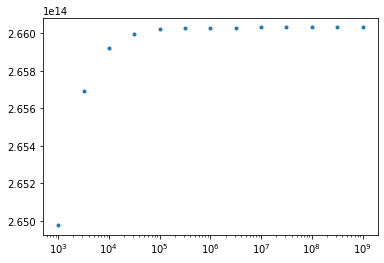

In [26]:
# Plot the l2_penalty values in the x axis and the cross-validation error in the y axis.
# Using plt.xscale('log') will make your plot more intuitive.

plt.plot(penalty_list,list1,'.')
plt.xscale('log')

Once you found the best value for the L2 penalty using cross-validation, it is important to retrain a final model on all of the training data using this value of `l2_penalty`. This way, your final model will be trained on the entire dataset.

In [27]:
poly15_data_tr = polynomial_dataframe(train_valid_shuffled['sqft_living'], 15)
my_features_15 =poly15_data_tr.columns
poly15_data_tr['price'] = train_valid_shuffled['price'] # add price to the data since it's the target
l2_penalty = 1000
model=Ridge(alpha=l2_penalty,normalize=True)
model.fit(poly15_data_tr[my_features_15],poly15_data_tr['price'])


Ridge(alpha=1000, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)

***QUIZ QUESTION: Using the best L2 penalty found above, train a model using all training data. What is the RSS on the TEST data of the model you learn with this L2 penalty? ***

In [28]:
poly15_data_te = polynomial_dataframe(test['sqft_living'], 15)
my_features_15 =poly15_data_te.columns
y_v=model.predict(poly15_data_te)
err=test['price']-y_v
serr=(err*err)
rss=sum(serr)
print(rss)

283856861224150.75
